## Grupo 04
- Ana Beatriz Lana Maciel MoreiraArmond (202165501B)
- Davi Esteves dos Santos (202065504B)
- Gabriel Frasson Costa (202035001)

# Conhecendo e Pré-processando os Dados
___


## Artibutos da Base de Dados (consertar):



- **Sexo** (M/F)
- **Idade** (número inteiro não negativo)
- **Altura** (número real com aproximação de duas casas decimais - metros)
- **Peso** (número real com aproximação de duas casas decimais - kg)
- **Histórico de Obesidade na Família** (S/N)
- **Consome Comida Calórica**: indica se a pessoa consome comida calórica frequentemente (S/N)
- **Consome Vegetais**: indica se a pessoa consome vegetais frequentemente em suas refeições (S/N)
- **Número de Refeições**: quantidade de refeições principais são feitas diariamente (número inteiro não negativo)
- **Come entre Refeições**: se come durante as refeições (S/N)
- **Fuma**: se fuma (S/N)
- **Consumo Diário de Água**: quantidade de água consumida diariamente (número real com aproximação de duas casas decimais - litros)
- **Frequência de Atividade Física**: qual a frequência de realização de atividades físicas (número real com aproximação de duas casas decimais - metros)
- **Tempo usando Eletrônicos**: quanto tempo gasta usando equipamentos eletrônicos, tais como celular, televisão, computador e videogame (número real com aproximação de duas casas decimais - horas)
- **Consumo de Álcool**: com que frequência há consumo de bebidas alcoólicas (não, às vezes, frequentemente)
- **Tipo de Transporte**: qual o tipo de transporte usado com frequência (transporte público, carro, moto, caminhada, outro)

## Objetivo do Trabalho
O objetivo deste segundo trabalho é descrever o conjunto de dados apresentado e adequá-lo à próxima etapa do processo de mineração (agrupamento).

Deve-se apresentar:

(1) Análises numéricas e gráficas de modo a descrever/entender os dados.
    As conclusões correspondentes a cada análise de dados e a cada gráfico devem estar escritas nos slides ou no notebook (se preferirem usá-lo).

(2) Tratamento dos dados: substituição de valores ausentes, tratamento de inconsistências, remoção de duplicidades, detecções de outliers, normalização e outros ajustes que considerem importantes.
 ___


In [34]:
# Importando Bibliotecas
from scipy.stats import zscore
from AnalysisUtils import *
from sklearn.preprocessing import StandardScaler

## Classes e funções

In [35]:
def encode_string_columns(df):
  for col in df.select_dtypes(include=['object', 'category']).columns:
    # Check if the column is binary with values "sim" and "nao"
    if df[col].isin(["sim", "nao"]).all():
      df[f"{col}_"] = df[col].map({"sim": 1, "nao": 0})
    else:
      df[f"{col}_"] = pd.factorize(df[col])[0]
  return df

# no need for an advanced techinice for replacing missing values as most missing values represent less than 1% of the data
def fill_missing_data(df):
  for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
      df[col] = df[col].fillna(df[col].mean())
    else:
      if df[col].notna().any():
        df[col] = df[col].fillna(df[col].mode()[0])
  return df

def detect_outliers(df):
  z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
  outliers = z_scores > 3  # Consider values with Z-score greater than 3 as outliers
  return outliers.sum()

def analyze_numerical_column(row):
  print_simple_metrics(row)
  boxplot_with_quartiles(row, yscale='linear')
  create_filtered_histograms(row, log=False, filters=None, color='blue', bins=100)

def calculate_group_metric(df, category_columns, numerical_columns, metric='median'):
  result_list = []
  
  for i in range(len(category_columns)):
    for value in df[category_columns[i]].unique():
      group_df = df[df[category_columns[i]] == value]
      
      if metric == 'median':
        group_metric = group_df[numerical_columns].median()
      else:
        group_metric = group_df[numerical_columns].mean()
      
      group_metric['category'] = f"{category_columns[i]}: {value}"
      result_list.append(group_metric)

  result_df = pd.DataFrame(result_list)
  
  return result_df

def plot_sorted_group_metric(result_df, numerical_columns, metric='median'):
  for col in numerical_columns:
    # Sort the result DataFrame by the median of the current column
    sorted_df = result_df.set_index('category').sort_values(by=col).reset_index()

    # Normalize the median values for coloring
    norm = plt.Normalize(sorted_df[col].min(), sorted_df[col].max())
    cmap = plt.cm.viridis  # You can change this to another colormap, e.g., 'plasma', 'inferno', etc.

    # Create a new figure for each numerical column
    plt.figure(figsize=(10, 6))

    # Create the gradient bars by mapping the median values to the color map
    bars = plt.bar(sorted_df['category'], sorted_df[col], color=cmap(norm(sorted_df[col])), width=0.6)

    # Set labels and title for the plot
    plt.xlabel('Category')
    plt.ylabel(f'{metric} of {col}')
    plt.title(f'Sorted {metric}s of {col} by Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add a color bar to indicate the gradient scale
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca())
    cbar.set_label(f'Median Value of {col}')

    # Show the plot
    plt.show()

def plot_all_category_columns(df, category_columns, color='skyblue', top=10):
  num_columns = len(category_columns)
  rows = (num_columns // 3) + (num_columns % 3 > 0)

  fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
  axes = axes.flatten()

  for idx, column in enumerate(category_columns):
    ax = axes[idx]

    # Get the value counts for the encoded column
    result_df = df[column].value_counts().reset_index()
    result_df.columns = [column, 'Count']
    result_df['Percentage'] = (result_df['Count'] / result_df['Count'].sum()) * 100

    # Keep only top N values if specified
    result_df = result_df.head(top)

    # Plot the bar chart
    result_df.plot(kind='bar', x=column, y='Count', color=color, ax=ax, legend=False)

    ax.set_title(f"Value Counts of {column}", fontsize=12, pad=20)
    ax.set_xlabel('Values', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    for i, (count, pct) in enumerate(zip(result_df['Count'], result_df['Percentage'])):
      ax.text(i, count + 0.5, f'{count} / {pct:.1f}%', ha='center', va='bottom')

  # Remove any empty axes
  for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

  plt.subplots_adjust(hspace=0.5, wspace=0.3)
  plt.tight_layout()
  plt.show()

def scale_numerical_data(df, columns):
  scaler = StandardScaler()
  df[columns] = scaler.fit_transform(df[columns])
  return df

def scale_and_prepare_data(df, categorical_columns, numerical_columns):
  print(df.columns)

  # One-hot encode categorical columns
  df_dummies = pd.get_dummies(df[categorical_columns], drop_first=False)

  # Initialize StandardScaler
  scaler = StandardScaler()

  # Scale the specified numerical columns
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

  # Scale the one-hot encoded categorical columns (df_dummies)
  df_dummies_scaled = scaler.fit_transform(df_dummies)

  # Convert the scaled dummies back to a DataFrame and assign correct column names manually
  df_dummies_scaled = pd.DataFrame(df_dummies_scaled, columns=df_dummies.columns, index=df.index)

  # Concatenate the scaled numerical columns with the scaled one-hot encoded columns
  df = pd.concat([df[numerical_columns], df_dummies_scaled], axis=1)

  return df

def encode_string_column(df, string_column, values, new_column_name=None):
  if df[string_column].isin(values).all():
    df[f"{new_column_name or string_column}"] = df[string_column].map({ value: index for index, value in enumerate(values) })
    
  return df

In [36]:
numerical_columns = ['idade', 'idade_int', 'altura', 'peso', 'consome_vegetais', 'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua', 'consumo_diario_agua_int', 'frequencia_atividade_fisica', 'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos', 'tempo_usando_eletronicos_int']

category_columns = ['sexo', 'historico_obesidade_familia', 'consome_comida_calorica', 'come_entre_refeicoes', 'fuma', 'consumo_alcool', 'tipo_transporte']

category_columns_ = ['sexo_', 'historico_obesidade_familia_', 'consome_comida_calorica_', 'come_entre_refeicoes_', 'fuma_', 'consumo_alcool_', 'tipo_transporte_']

___

# 1) Construindo a Base de Dados

In [37]:
# Importando dados
df = pd.read_csv('data/trabalho2_dados_4.csv')

# print('Antes do Input')
# print(df.loc[602], end='\n\n')
# print(df[df.eq(df.loc[1]).all(axis=1)], end='\n\n')

df = df.drop_duplicates(df, keep='first') # remoção de ~250 entradas duplicadas

df = fill_missing_data(df) # substituindo valores faltantes numéricos pela media e categóricos pela moda

# print('Depois do Input')
# print(df.loc[602], end='\n\n')
# print(df[df.eq(df.loc[1]).all(axis=1)], end='\n\n')

In [38]:
df['idade_int'] = np.floor(df['idade'])
df['n_refeicoes_int'] = df['n_refeicoes'].round()
df['consome_vegetais_int'] = df['consome_vegetais'].round()
df['consumo_diario_agua_int'] = df['consumo_diario_agua'].round()
df['frequencia_atividade_fisica_int'] = df['frequencia_atividade_fisica'].round()
df['tempo_usando_eletronicos_int'] = df['tempo_usando_eletronicos'].round()
df = encode_string_columns(df) # encodando colunas de string
# df = df.drop_duplicates(df, keep='first') # remoção de ~250 entradas duplicadas (substituição de valores faltantes e transformação direta em int nao criaram novas duplicados apenas 1 para o caso de substituição
df

,sexo,idade,altura,peso,historico_obesidade_familia,consome_comida_calorica,consome_vegetais,n_refeicoes,come_entre_refeicoes,fuma,...,consumo_diario_agua_int,frequencia_atividade_fisica_int,tempo_usando_eletronicos_int,sexo_,historico_obesidade_familia_,consome_comida_calorica_,come_entre_refeicoes_,fuma_,consumo_alcool_,tipo_transporte_
0,M,31.264628,1.803129,91.052215,sim,sim,2.418910,3.000000,as vezes,nao,...,1.0,1.0,0.0,0,1,1,0,0,0,0
1,M,21.000000,1.620000,70.000000,nao,sim,2.000000,1.000000,nao,nao,...,3.0,1.0,0.0,0,0,1,1,0,0,0
2,F,18.019572,1.701378,50.088468,nao,sim,1.601236,3.433908,as vezes,nao,...,1.0,1.0,1.0,1,0,1,0,0,0,0
3,F,25.918524,1.621231,104.986792,sim,sim,3.000000,2.688569,as vezes,nao,...,2.0,0.0,1.0,1,1,1,0,0,0,0
4,F,33.000000,1.590000,60.000000,nao,sim,3.000000,1.000000,frequentemente,nao,...,2.0,0.0,0.0,1,0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,F,26.000000,1.640745,110.919646,sim,sim,2.418910,3.000000,as vezes,nao,...,3.0,1.0,0.0,1,1,1,0,0,0,0
1092,M,26.000000,1.700000,70.000000,sim,nao,3.000000,1.000000,frequentemente,nao,...,2.0,2.0,0.0,0,1,0,2,0,2,0
1094,F,16.000000,1.570000,49.000000,nao,sim,2.000000,4.000000,sempre,nao,...,2.0,0.0,1.0,1,0,1,3,0,0,0
1097,M,31.346845,1.823545,126.460936,sim,sim,2.938801,3.000000,as vezes,sim,...,1.0,1.0,1.0,0,1,1,0,1,0,0


In [39]:
detect_outliers(df) 
# Não foram detectados outliers relevantes nas métricas numéricas
# a unica metrica com outliers usando z_score foi a de idade, mas essa distribuição não é normal, e foram apenas 7 encontrados
# nas métricas categóricas, isso removeria certas do categorias do dataset, portanto, não é necessário remover outliers neste dataset

np.int64(104)

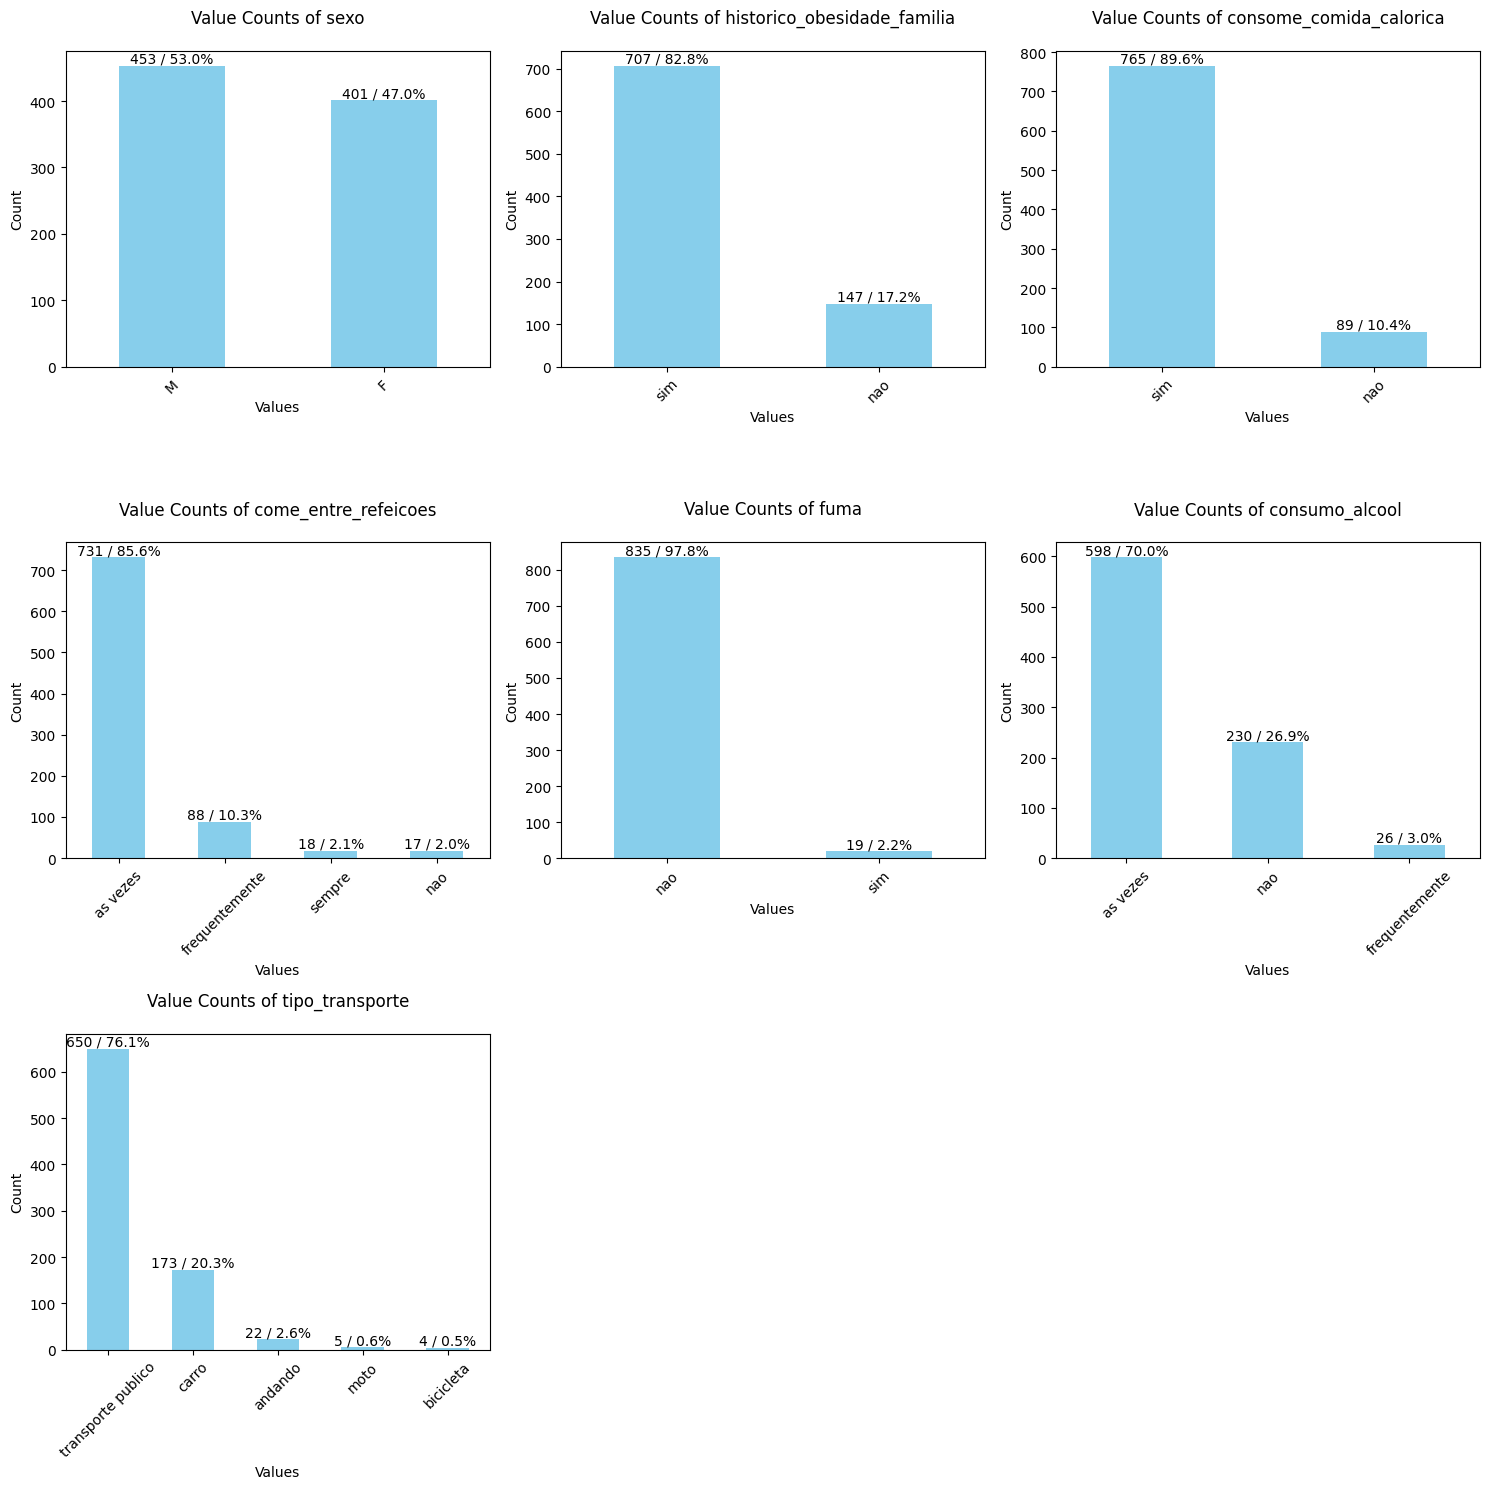

In [40]:
plot_all_category_columns(df, category_columns, color='skyblue', top=10)


--------------------------------------

métricas gerais para idade
média: 24.29774674123337
mediana: 22.983017
desvio padrão: 6.121048924016714
kurtosis: 2.369477540482684
skewness: 1.4416805785180147

--------------------------------------



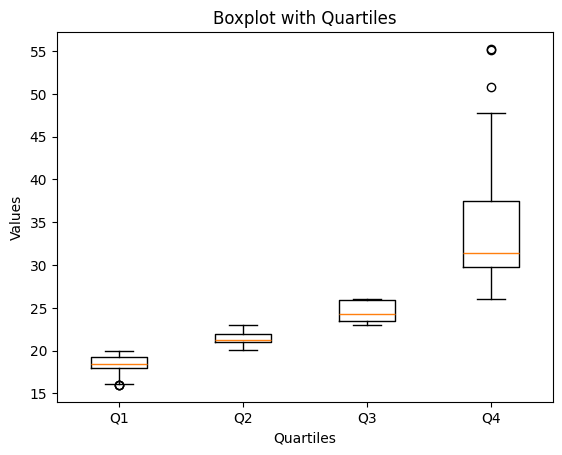


--------------------------------------

Histogramas para a coluna idade com log: False e bins: 100
idade <= 55.24625


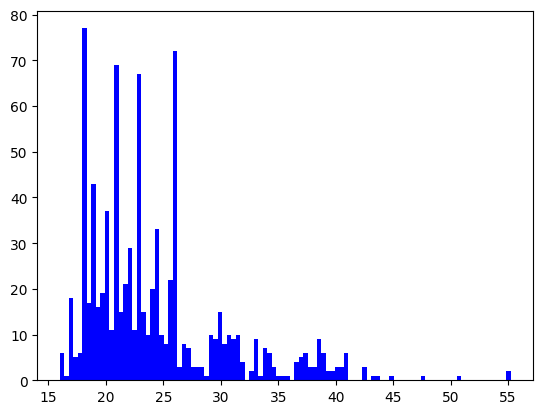


--------------------------------------

idade <= 26.0


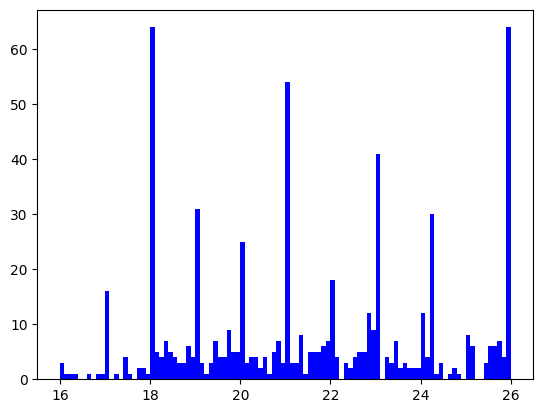


--------------------------------------

idade <= 22.983017


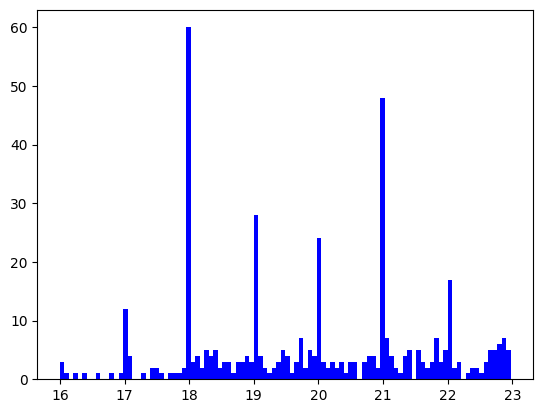


--------------------------------------

idade <= 20.0


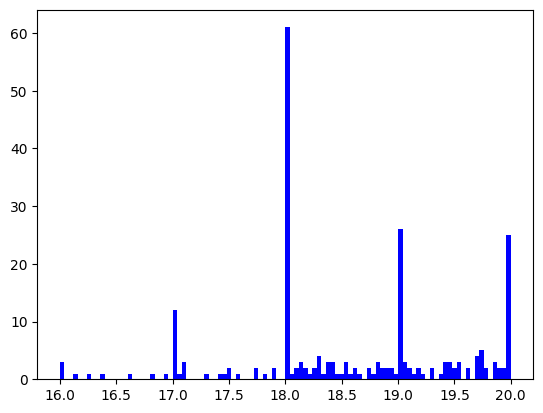


--------------------------------------


--------------------------------------

métricas gerais para idade_int
média: 23.962529274004684
mediana: 22.0
desvio padrão: 6.06885085398279
kurtosis: 2.4609965841550885
skewness: 1.4641429049723436

--------------------------------------



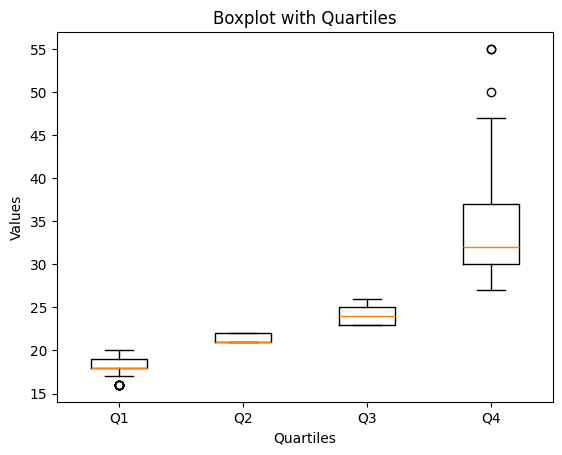


--------------------------------------

Histogramas para a coluna idade_int com log: False e bins: 100
idade_int <= 55.0


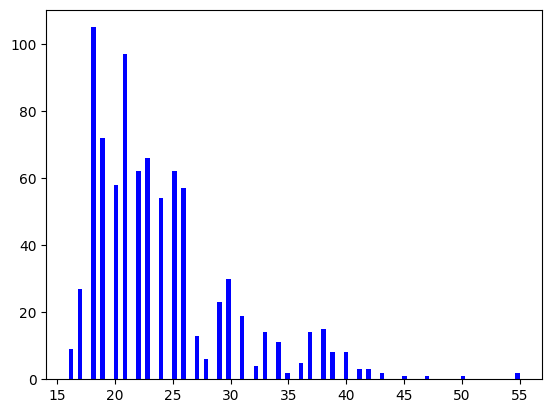


--------------------------------------

idade_int <= 26.0


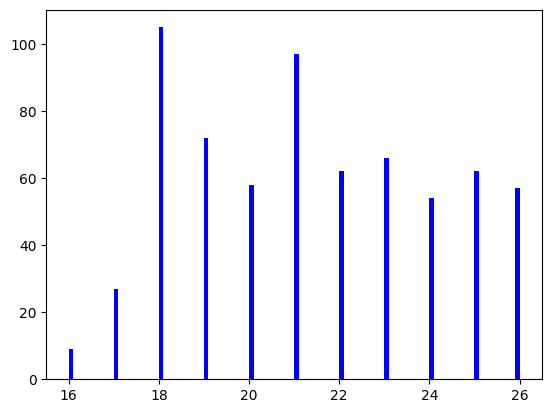


--------------------------------------

idade_int <= 22.0


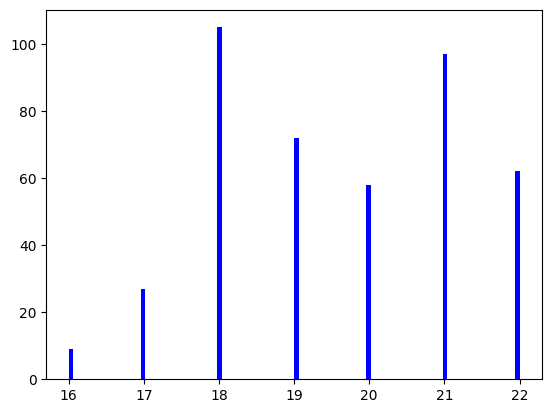


--------------------------------------

idade_int <= 20.0


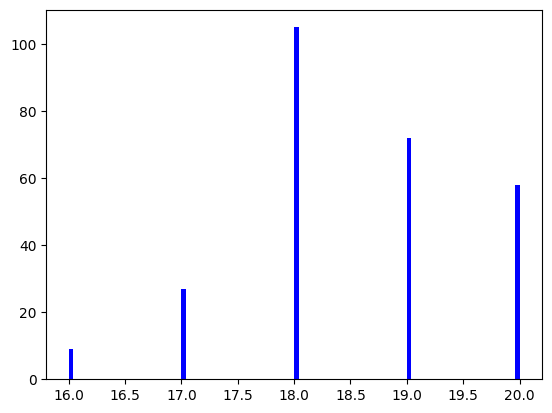


--------------------------------------


--------------------------------------

métricas gerais para altura
média: 1.7046815233532937
mediana: 1.7046815233532933
desvio padrão: 0.09374149525085836
kurtosis: -0.42469409659682267
skewness: -0.0770171686645744

--------------------------------------



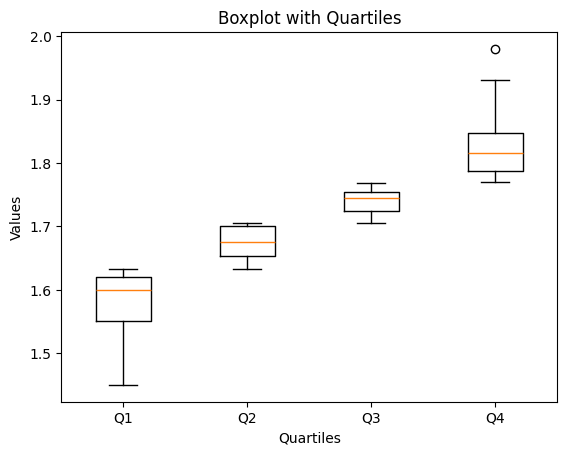


--------------------------------------

Histogramas para a coluna altura com log: False e bins: 100
altura <= 1.98


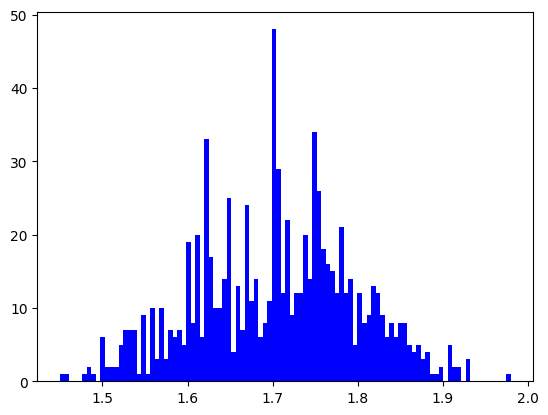


--------------------------------------

altura <= 1.7694415


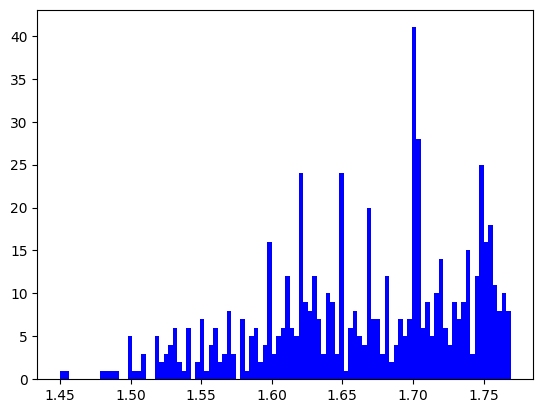


--------------------------------------

altura <= 1.7046815233532933


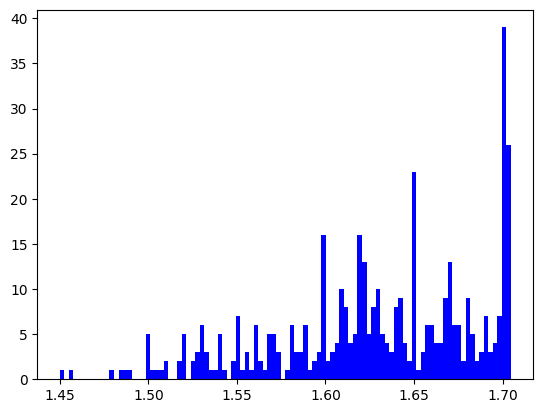


--------------------------------------

altura <= 1.63247375


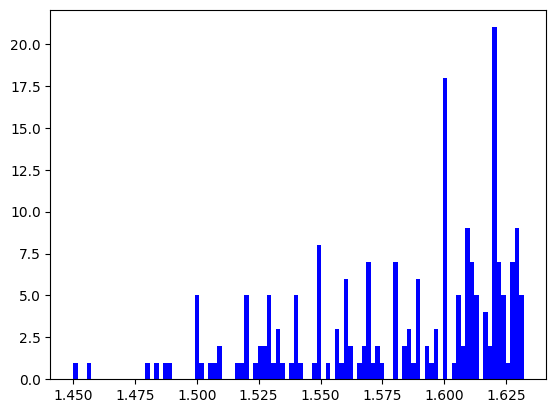


--------------------------------------


--------------------------------------

métricas gerais para peso
média: 88.2103415925926
mediana: 86.3927645
desvio padrão: 25.835535492056064
kurtosis: -0.7501557323750743
skewness: 0.13439215213773556

--------------------------------------



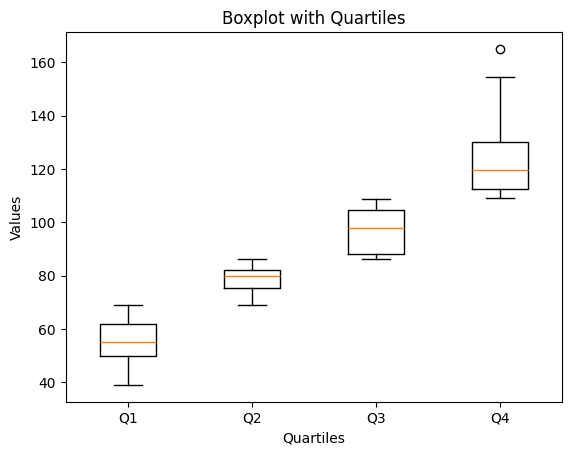


--------------------------------------

Histogramas para a coluna peso com log: False e bins: 100
peso <= 165.057269


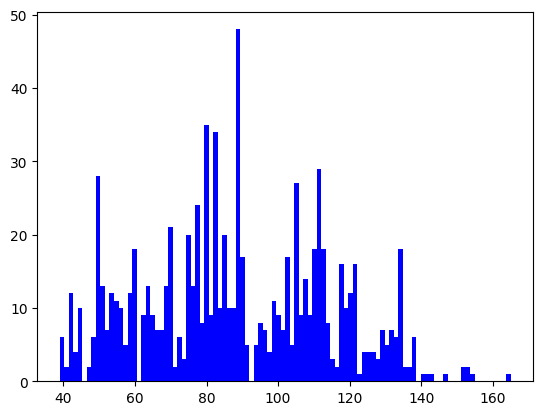


--------------------------------------

peso <= 108.9836435


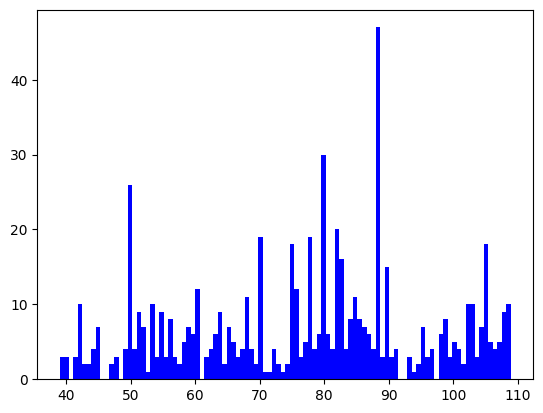


--------------------------------------

peso <= 86.3927645


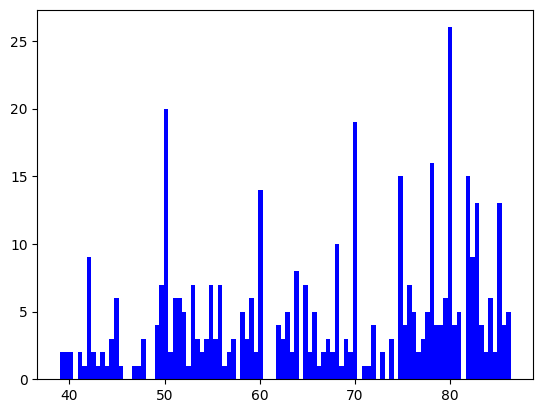


--------------------------------------

peso <= 68.92645275


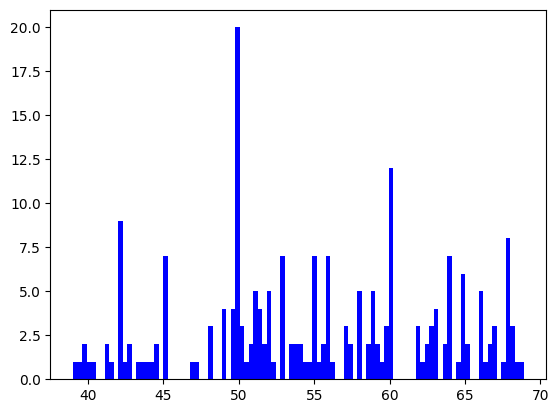


--------------------------------------


--------------------------------------

métricas gerais para consome_vegetais
média: 2.4189098919902907
mediana: 2.418909891990291
desvio padrão: 0.5218494650055632
kurtosis: -0.6109213466482966
skewness: -0.3971370953496086

--------------------------------------



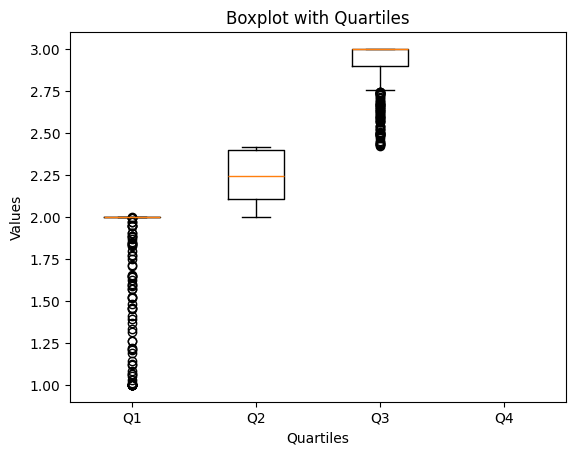


--------------------------------------

Histogramas para a coluna consome_vegetais com log: False e bins: 100
consome_vegetais <= 3.0


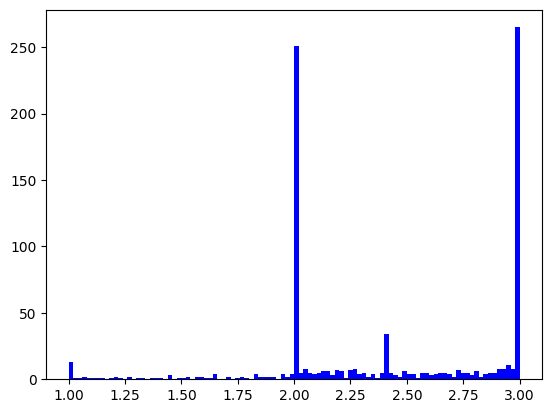


--------------------------------------

consome_vegetais <= 3.0


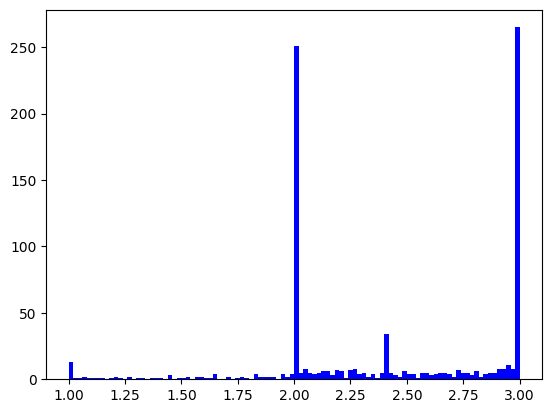


--------------------------------------

consome_vegetais <= 2.418909891990291


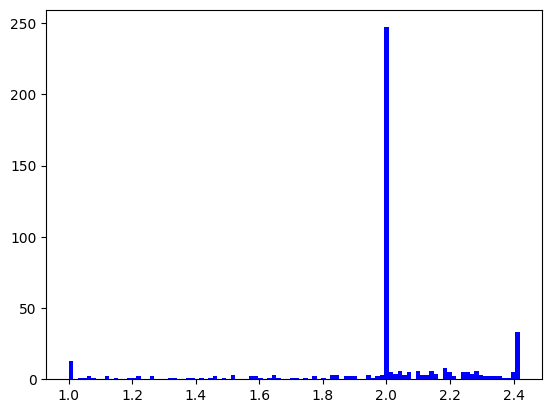


--------------------------------------

consome_vegetais <= 2.0


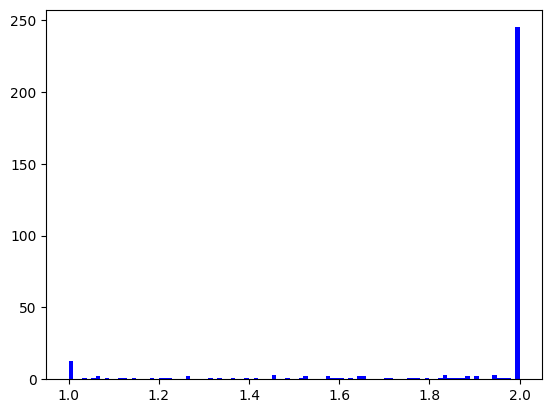


--------------------------------------


--------------------------------------

métricas gerais para consome_vegetais_int
média: 2.4074941451990632
mediana: 2.0
desvio padrão: 0.5710811587538305
kurtosis: -0.7866678033109307
skewness: -0.3140929403756152

--------------------------------------



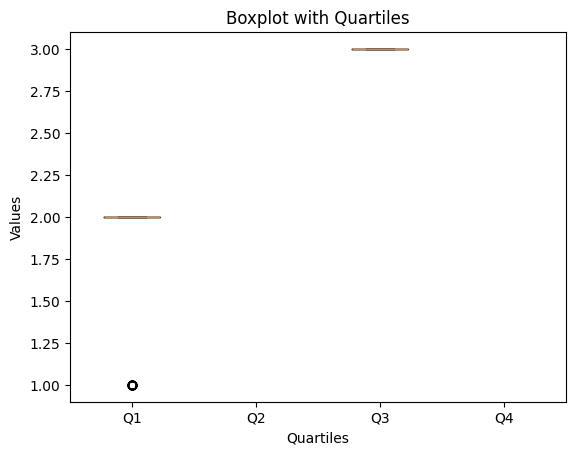


--------------------------------------

Histogramas para a coluna consome_vegetais_int com log: False e bins: 100
consome_vegetais_int <= 3.0


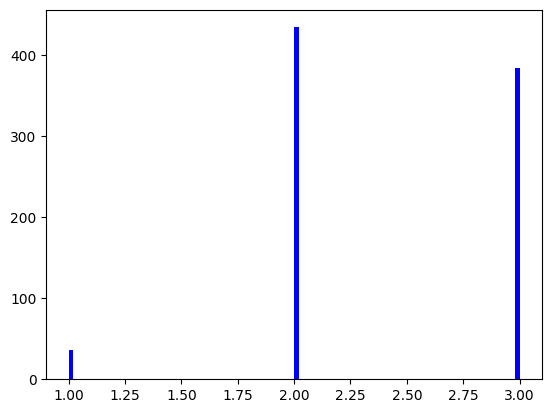


--------------------------------------

consome_vegetais_int <= 3.0


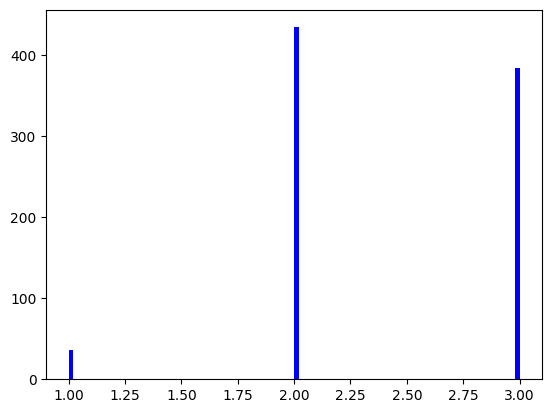


--------------------------------------

consome_vegetais_int <= 2.0


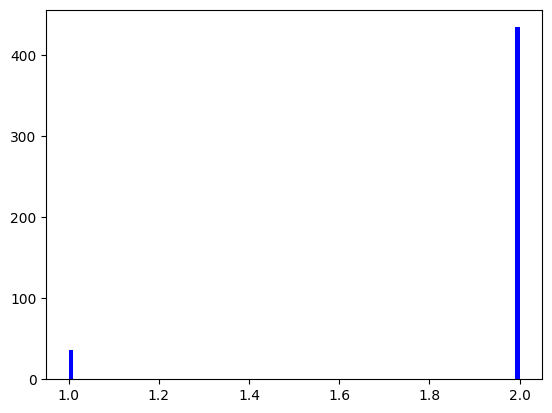


--------------------------------------

consome_vegetais_int <= 2.0


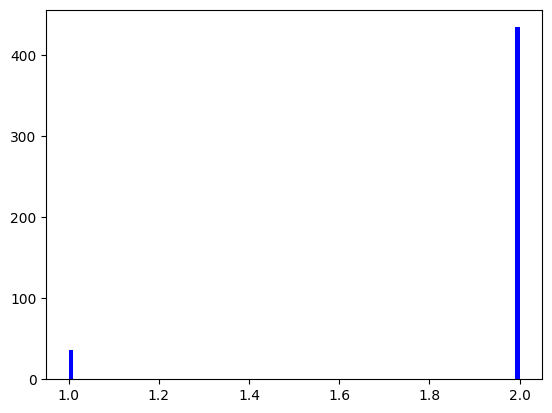


--------------------------------------


--------------------------------------

métricas gerais para n_refeicoes_int
média: 2.6978922716627634
mediana: 3.0
desvio padrão: 0.7808194556865596
kurtosis: 0.6550405437233899
skewness: -1.1756425297008446

--------------------------------------



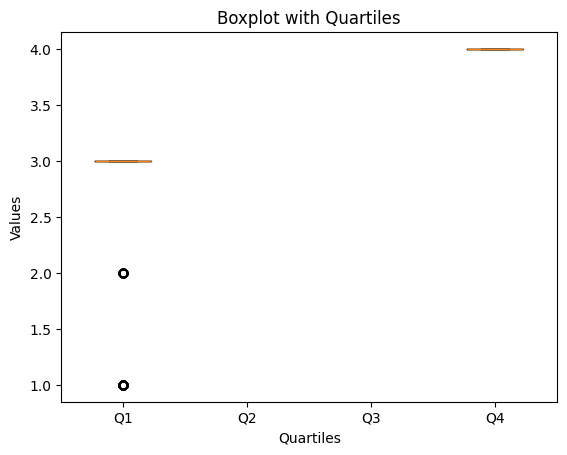


--------------------------------------

Histogramas para a coluna n_refeicoes_int com log: False e bins: 100
n_refeicoes_int <= 4.0


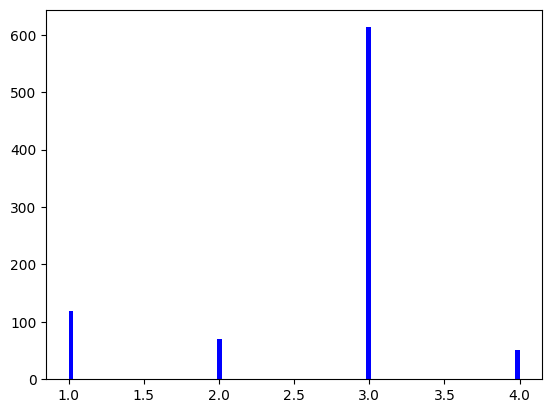


--------------------------------------

n_refeicoes_int <= 3.0


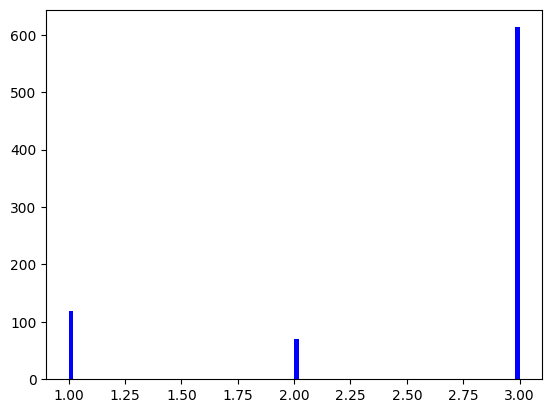


--------------------------------------

n_refeicoes_int <= 3.0


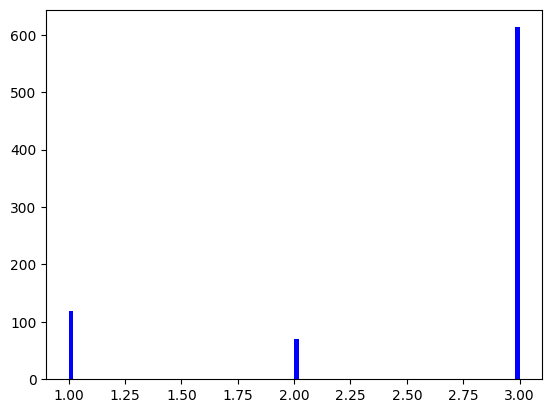


--------------------------------------

n_refeicoes_int <= 3.0


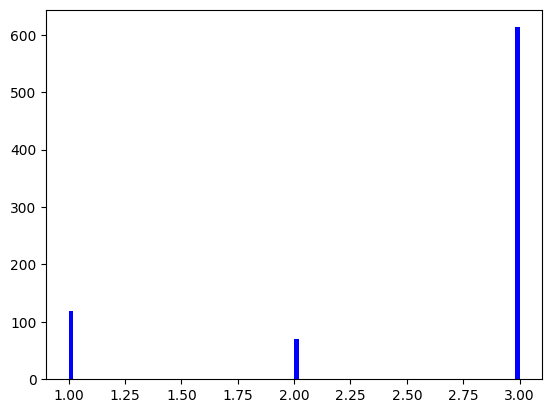


--------------------------------------


--------------------------------------

métricas gerais para consumo_diario_agua
média: 2.002235315018315
mediana: 2.0
desvio padrão: 0.6101410542692032
kurtosis: -0.8603356591021702
skewness: -0.11597795321921789

--------------------------------------



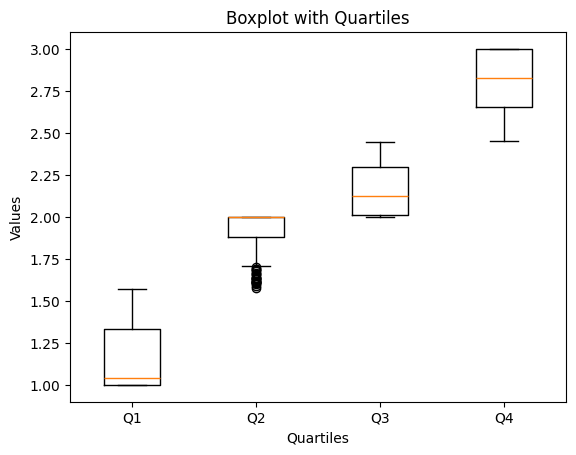


--------------------------------------

Histogramas para a coluna consumo_diario_agua com log: False e bins: 100
consumo_diario_agua <= 3.0


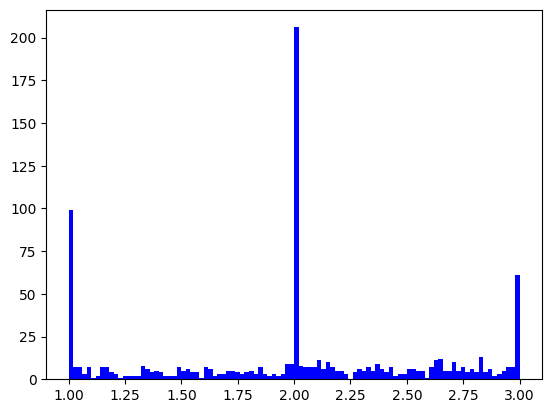


--------------------------------------

consumo_diario_agua <= 2.4518645


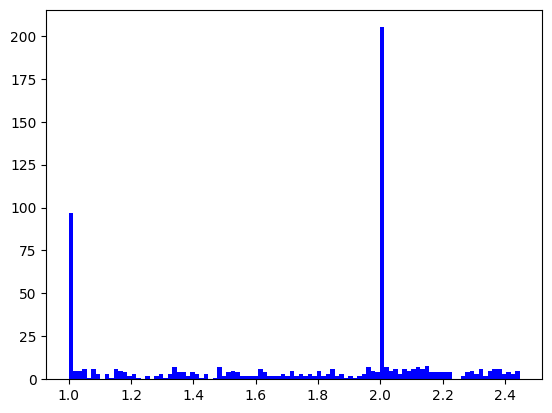


--------------------------------------

consumo_diario_agua <= 2.0


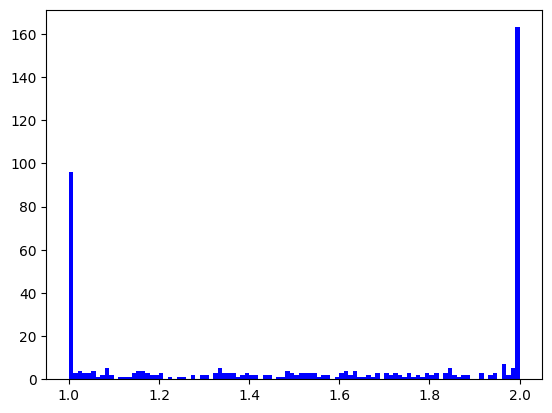


--------------------------------------

consumo_diario_agua <= 1.57244275


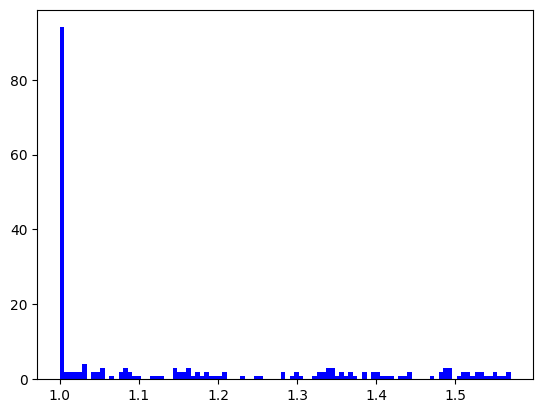


--------------------------------------


--------------------------------------

métricas gerais para consumo_diario_agua_int
média: 2.01288056206089
mediana: 2.0
desvio padrão: 0.6872292721286635
kurtosis: -0.8802740911869167
skewness: -0.016512650949283256

--------------------------------------



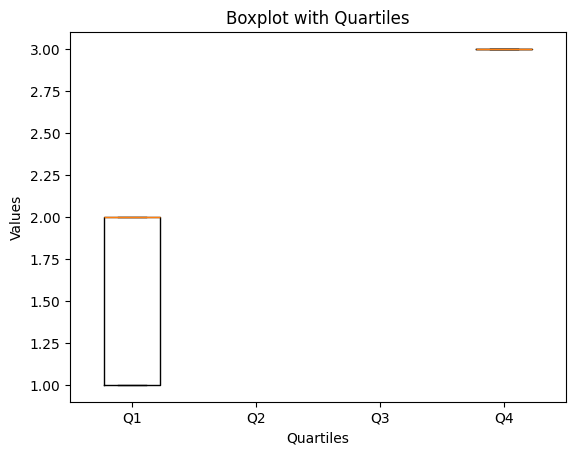


--------------------------------------

Histogramas para a coluna consumo_diario_agua_int com log: False e bins: 100
consumo_diario_agua_int <= 3.0


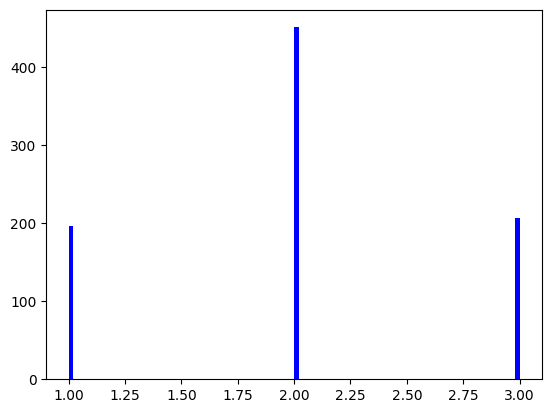


--------------------------------------

consumo_diario_agua_int <= 2.0


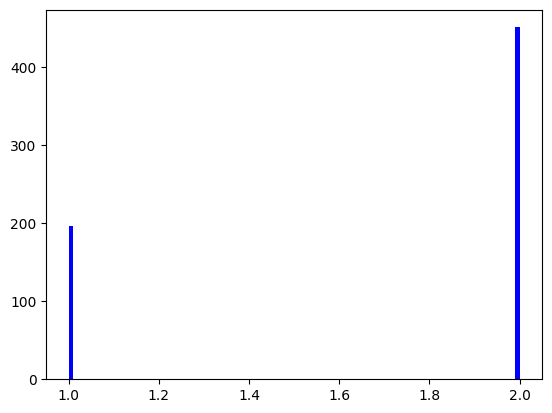


--------------------------------------

consumo_diario_agua_int <= 2.0


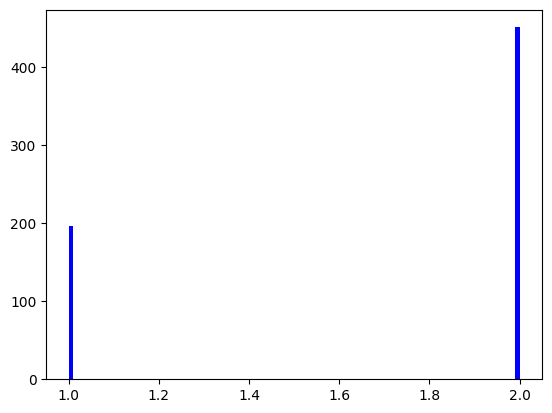


--------------------------------------

consumo_diario_agua_int <= 2.0


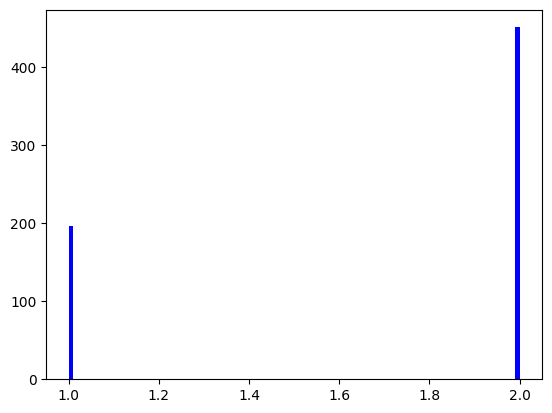


--------------------------------------


--------------------------------------

métricas gerais para frequencia_atividade_fisica
média: 0.985850297691373
mediana: 0.985850297691373
desvio padrão: 0.8376591107588814
kurtosis: -0.42893331642831445
skewness: 0.5706617459021197

--------------------------------------



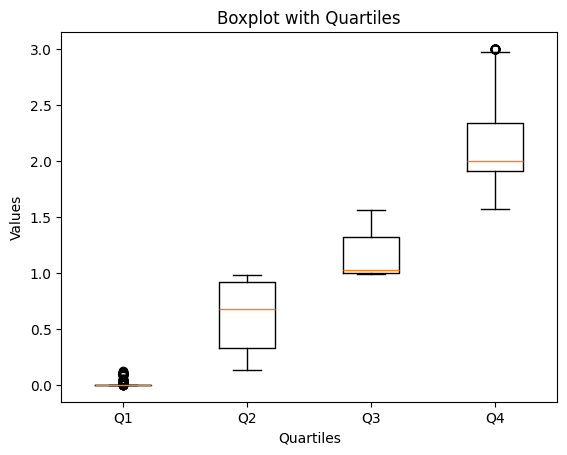


--------------------------------------

Histogramas para a coluna frequencia_atividade_fisica com log: False e bins: 100
frequencia_atividade_fisica <= 3.0


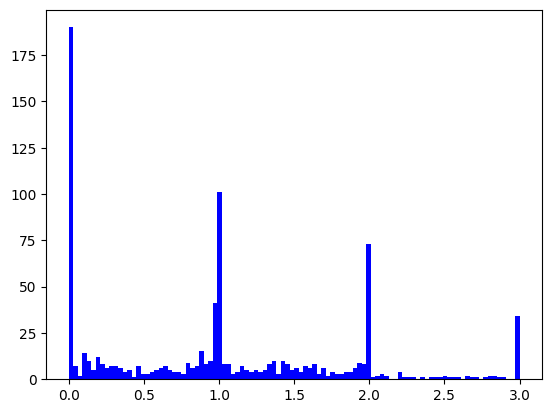


--------------------------------------

frequencia_atividade_fisica <= 1.569452


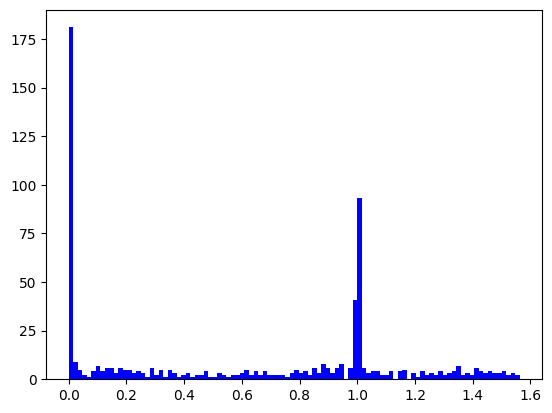


--------------------------------------

frequencia_atividade_fisica <= 0.985850297691373


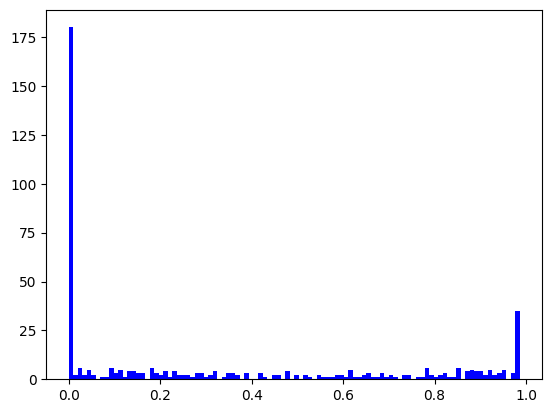


--------------------------------------

frequencia_atividade_fisica <= 0.12786325


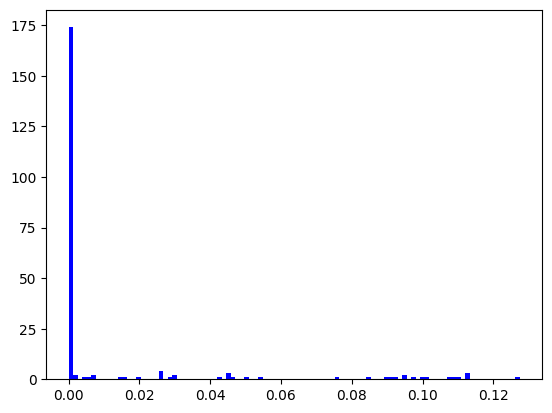


--------------------------------------


--------------------------------------

métricas gerais para frequencia_atividade_fisica_int
média: 0.977751756440281
mediana: 1.0
desvio padrão: 0.8826697242862638
kurtosis: -0.5260590349595855
skewness: 0.5447534252252059

--------------------------------------



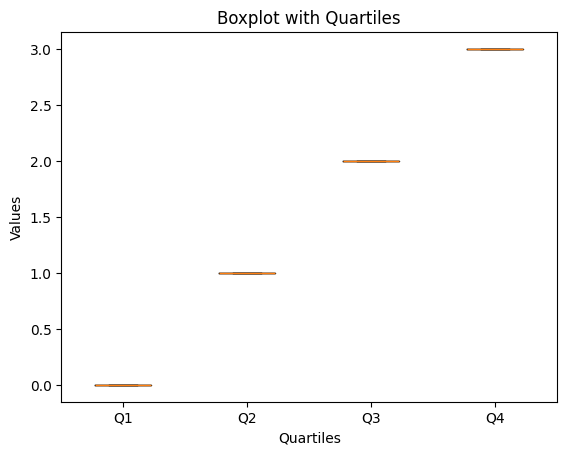


--------------------------------------

Histogramas para a coluna frequencia_atividade_fisica_int com log: False e bins: 100
frequencia_atividade_fisica_int <= 3.0


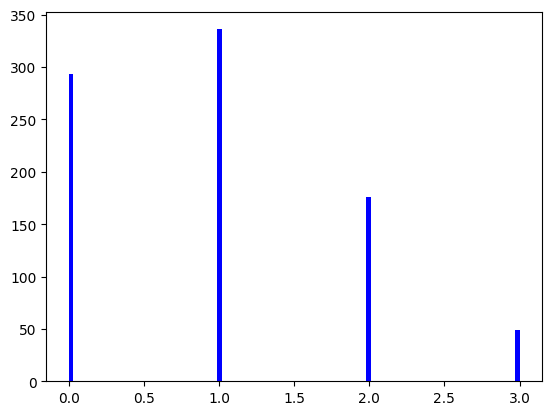


--------------------------------------

frequencia_atividade_fisica_int <= 2.0


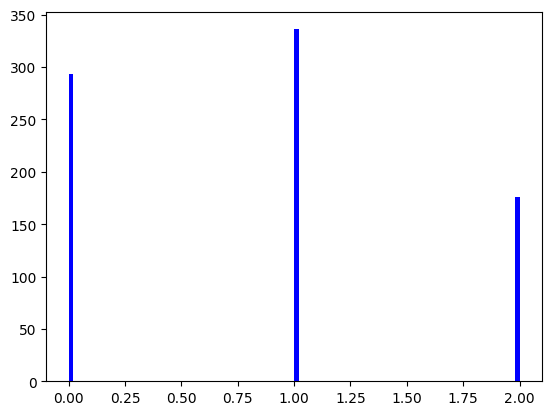


--------------------------------------

frequencia_atividade_fisica_int <= 1.0


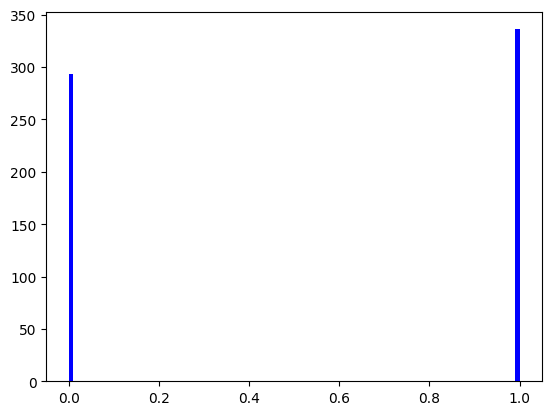


--------------------------------------

frequencia_atividade_fisica_int <= 0.0


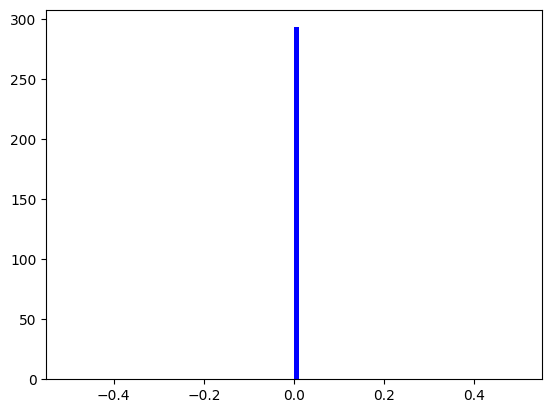


--------------------------------------


--------------------------------------

métricas gerais para tempo_usando_eletronicos
média: 0.6784862204819277
mediana: 0.6781976102409638
desvio padrão: 0.6138181726723946
kurtosis: -0.5876820311137814
skewness: 0.5857137849785683

--------------------------------------



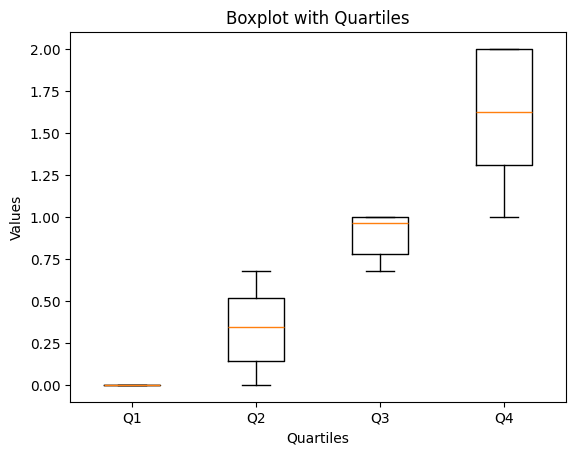


--------------------------------------

Histogramas para a coluna tempo_usando_eletronicos com log: False e bins: 100
tempo_usando_eletronicos <= 2.0


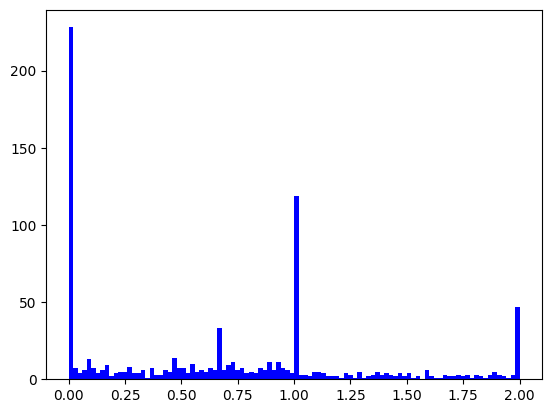


--------------------------------------

tempo_usando_eletronicos <= 1.0


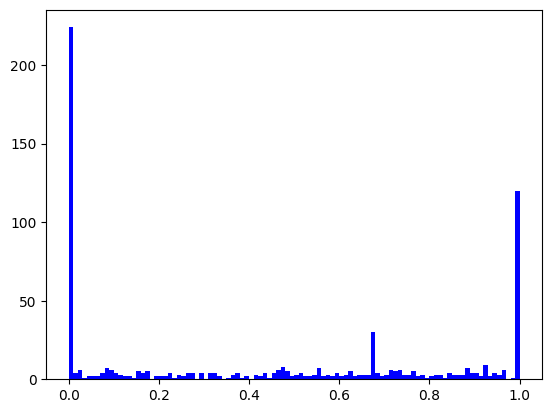


--------------------------------------

tempo_usando_eletronicos <= 0.6781976102409638


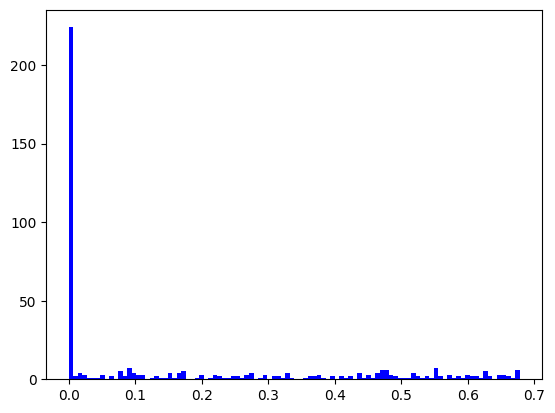


--------------------------------------

tempo_usando_eletronicos <= 0.0


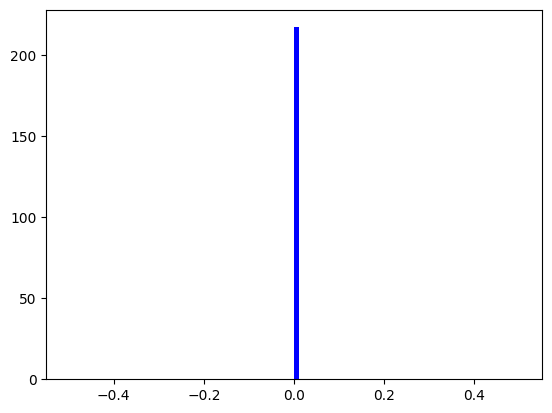


--------------------------------------


--------------------------------------

métricas gerais para tempo_usando_eletronicos_int
média: 0.689695550351288
mediana: 1.0
desvio padrão: 0.6751052376328871
kurtosis: -0.7939079711828443
skewness: 0.4667329961026912

--------------------------------------



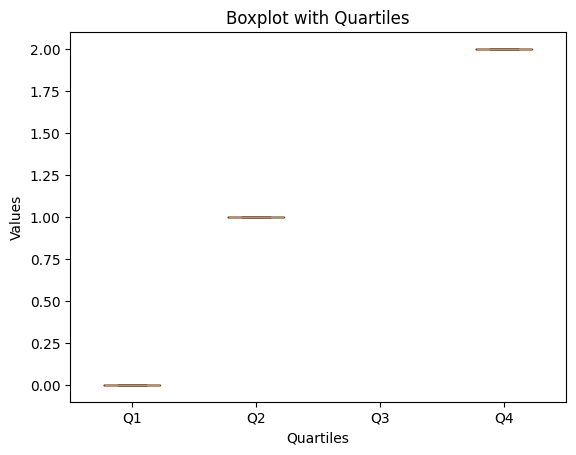


--------------------------------------

Histogramas para a coluna tempo_usando_eletronicos_int com log: False e bins: 100
tempo_usando_eletronicos_int <= 2.0


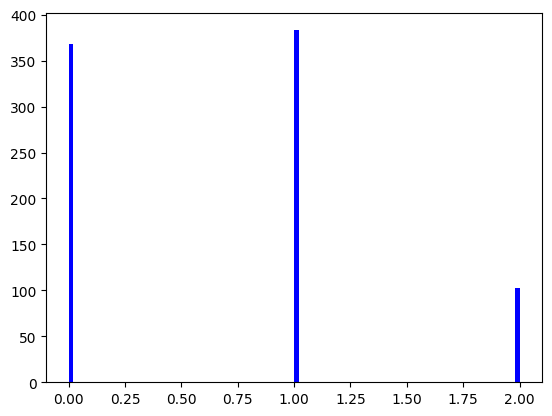


--------------------------------------

tempo_usando_eletronicos_int <= 1.0


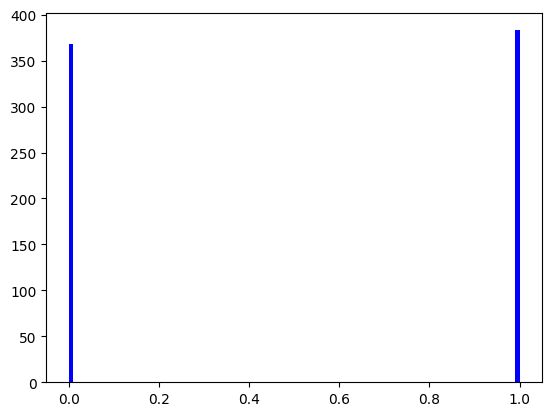


--------------------------------------

tempo_usando_eletronicos_int <= 1.0


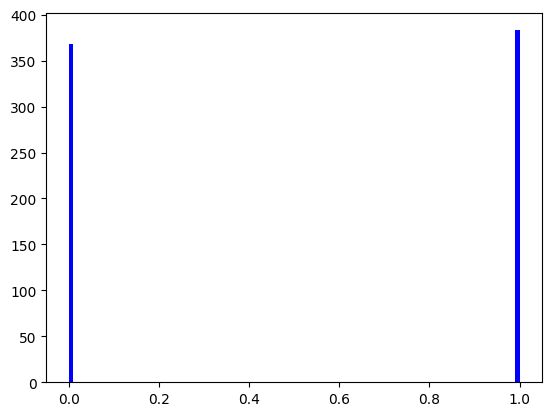


--------------------------------------

tempo_usando_eletronicos_int <= 0.0


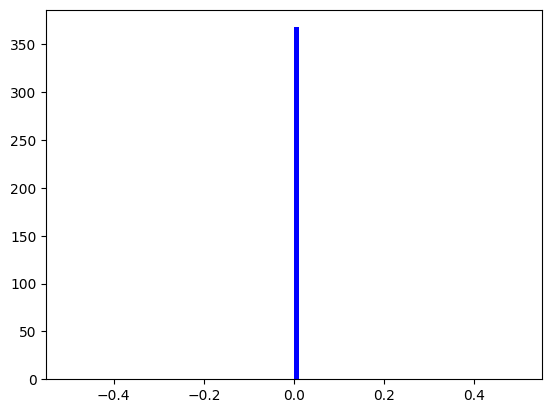


--------------------------------------



In [41]:
#idade possui distribuição com cauda
for row in numerical_columns:
  analyze_numerical_column(df[row]) 

In [42]:
result_df = calculate_group_metric(df, category_columns, numerical_columns, metric='mean') # seria interessante categorizar n_refeiçoes, vegetais, etc
result_df

,idade,idade_int,altura,peso,consome_vegetais,consome_vegetais_int,n_refeicoes_int,consumo_diario_agua,consumo_diario_agua_int,frequencia_atividade_fisica,frequencia_atividade_fisica_int,tempo_usando_eletronicos,tempo_usando_eletronicos_int,category
0,24.393337,24.075055,1.755687,91.588728,2.295625,2.273731,2.732892,2.043371,2.026490,1.105904,1.108168,0.689889,0.701987,sexo: M
1,24.189760,23.835411,1.647062,84.393860,2.558182,2.558603,2.658354,1.955766,1.997506,0.850228,0.830424,0.665605,0.675810,sexo: F
2,24.863540,24.500707,1.714472,93.962732,2.435488,2.418670,2.724187,2.035481,2.046676,0.964979,0.957567,0.670514,0.687412,historico_obesidade_familia: sim
3,21.576550,21.374150,1.657594,60.544081,2.339179,2.353741,2.571429,1.842341,1.850340,1.086232,1.074830,0.716829,0.700680,historico_obesidade_familia: nao
4,24.569668,24.216993,1.709191,90.344662,2.425577,2.411765,2.690196,2.004333,2.015686,0.955687,0.946405,0.684338,0.696732,consome_comida_calorica: sim
5,21.960447,21.775281,1.665920,69.864780,2.361601,2.370787,2.764045,1.984202,1.988764,1.245118,1.247191,0.628189,0.629213,consome_comida_calorica: nao
6,24.740431,24.372093,1.710703,92.269856,2.424013,2.413133,2.714090,2.020813,2.032832,0.958677,0.949384,0.672208,0.689466,come_entre_refeicoes: as vezes
7,20.824059,20.705882,1.637081,70.113289,1.990679,1.941176,1.764706,2.591582,2.588235,1.116259,1.176471,0.274620,0.235294,come_entre_refeicoes: nao
8,21.931950,21.761364,1.669589,61.690121,2.426537,2.420455,2.715909,1.768584,1.772727,1.149720,1.136364,0.799713,0.772727,come_entre_refeicoes: frequentemente
9,21.166667,21.166667,1.695556,70.095019,2.578828,2.555556,2.833333,1.833458,1.833333,1.165094,1.166667,0.722222,0.722222,come_entre_refeicoes: sempre


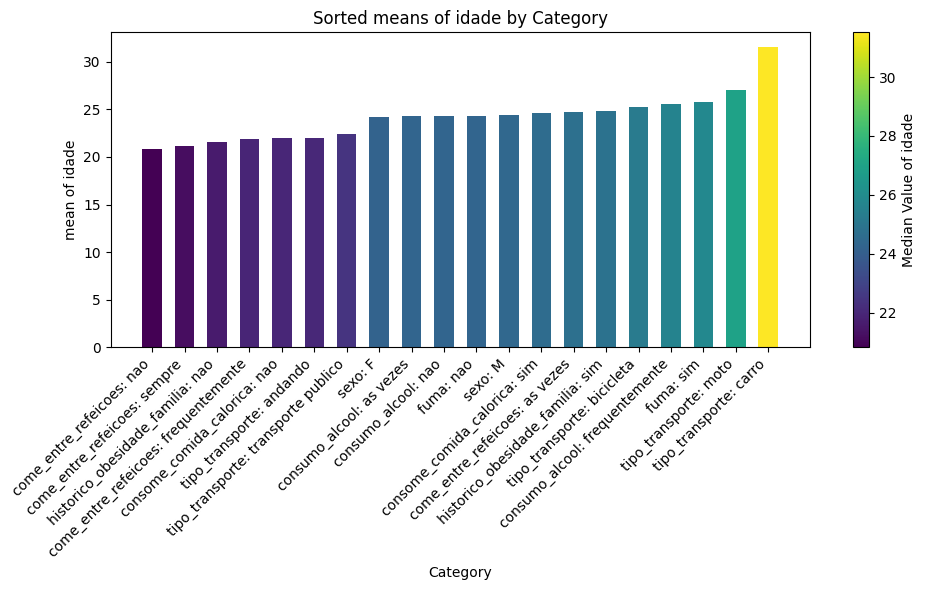

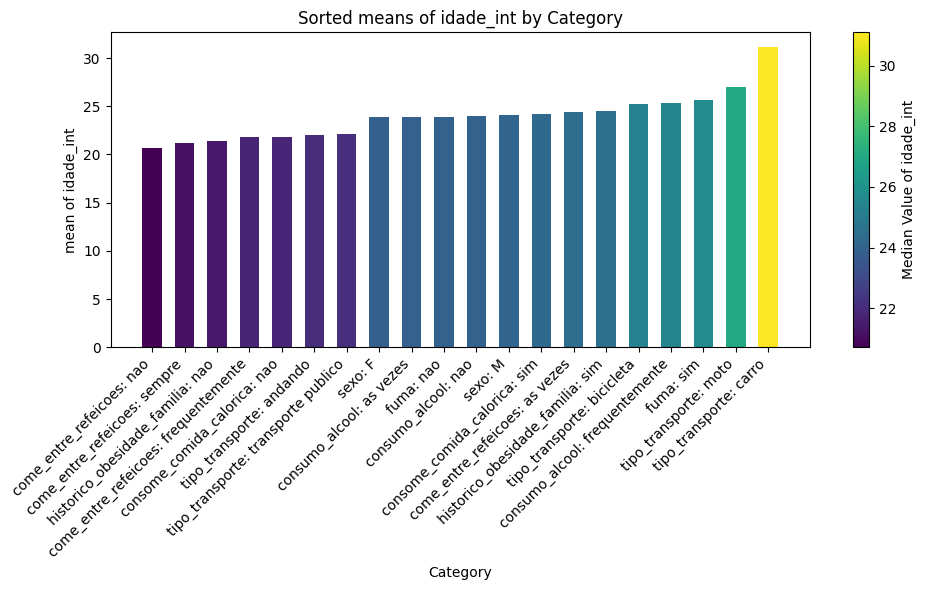

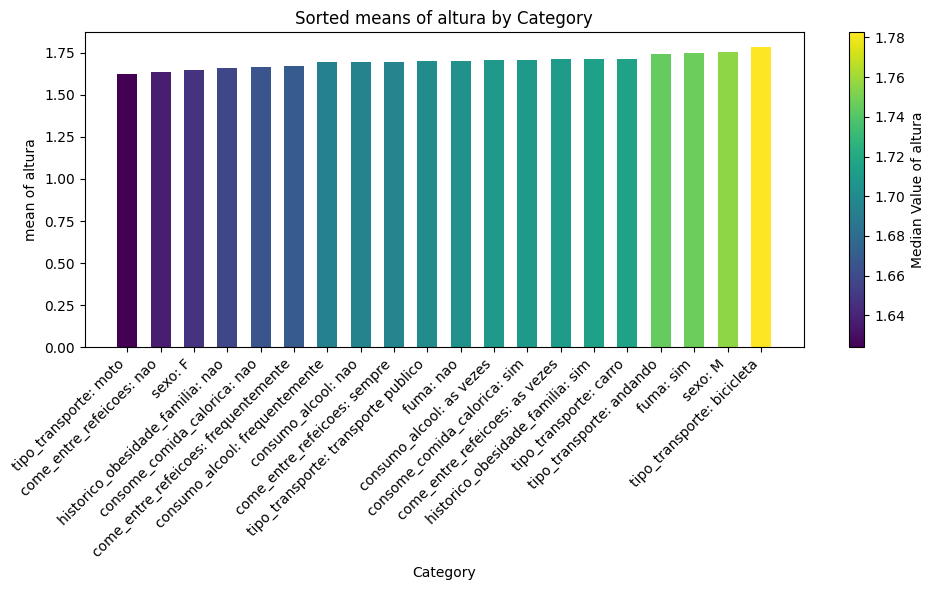

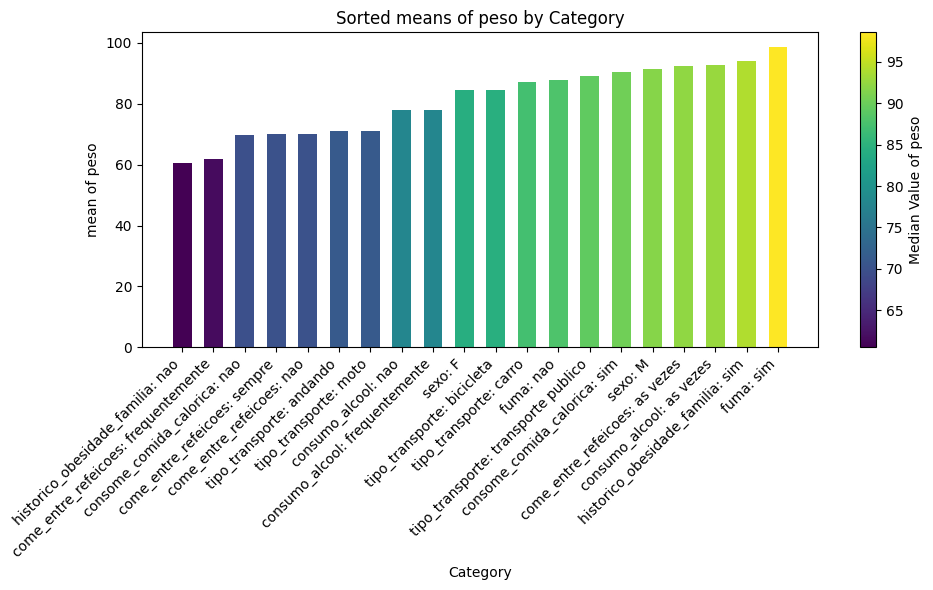

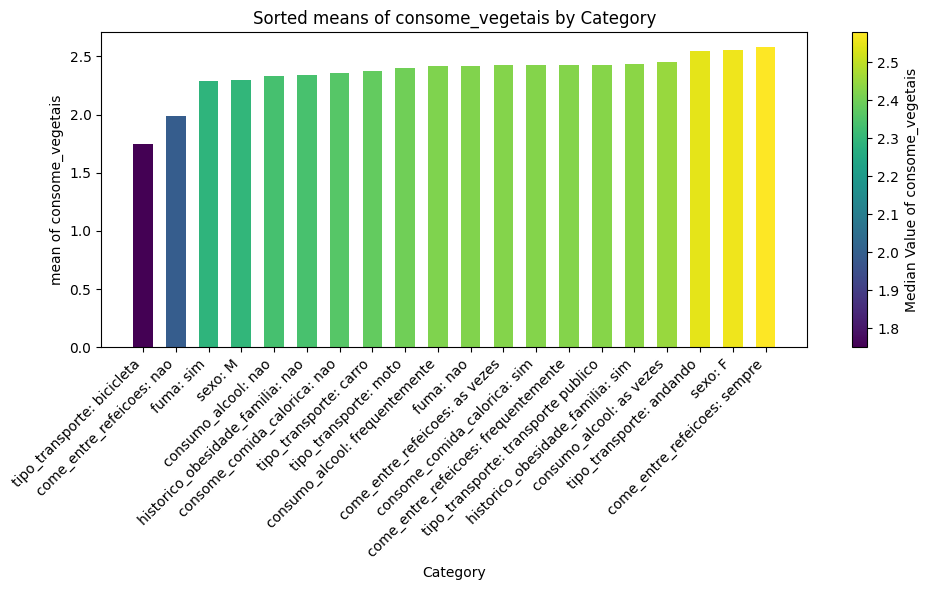

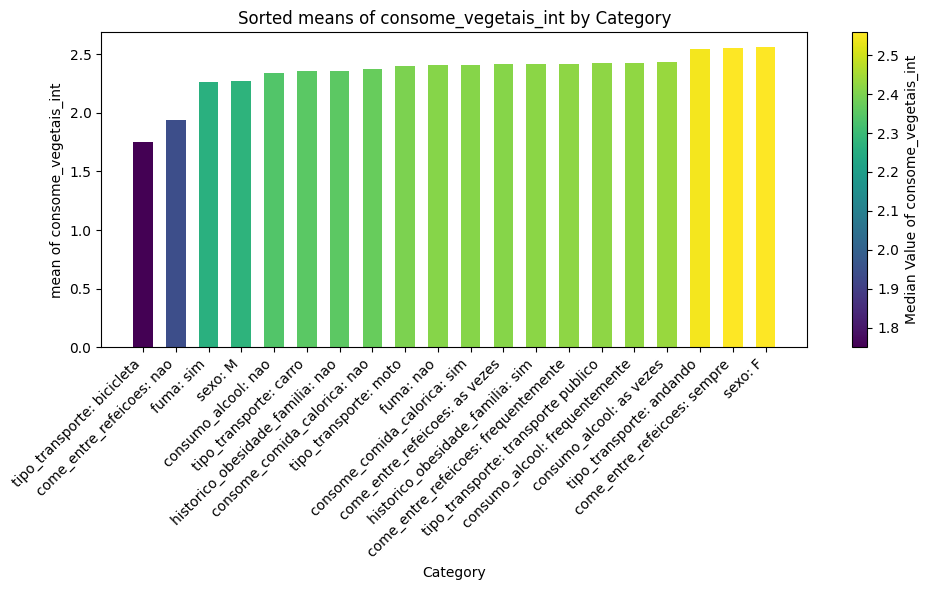

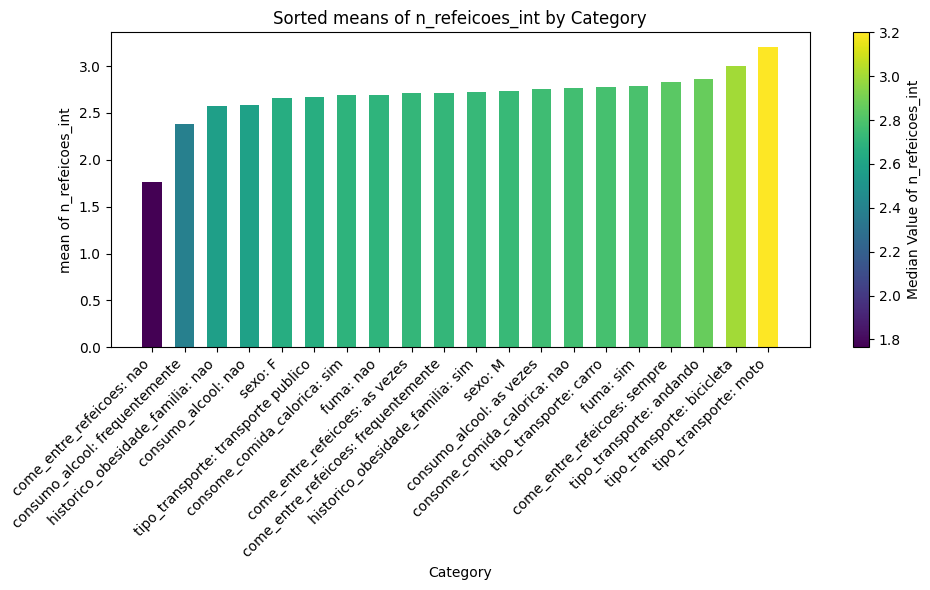

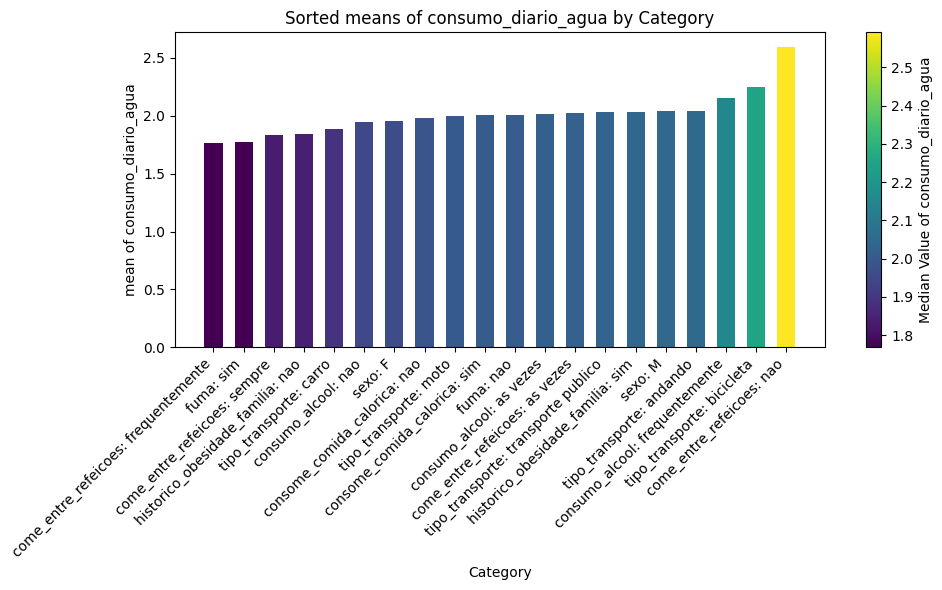

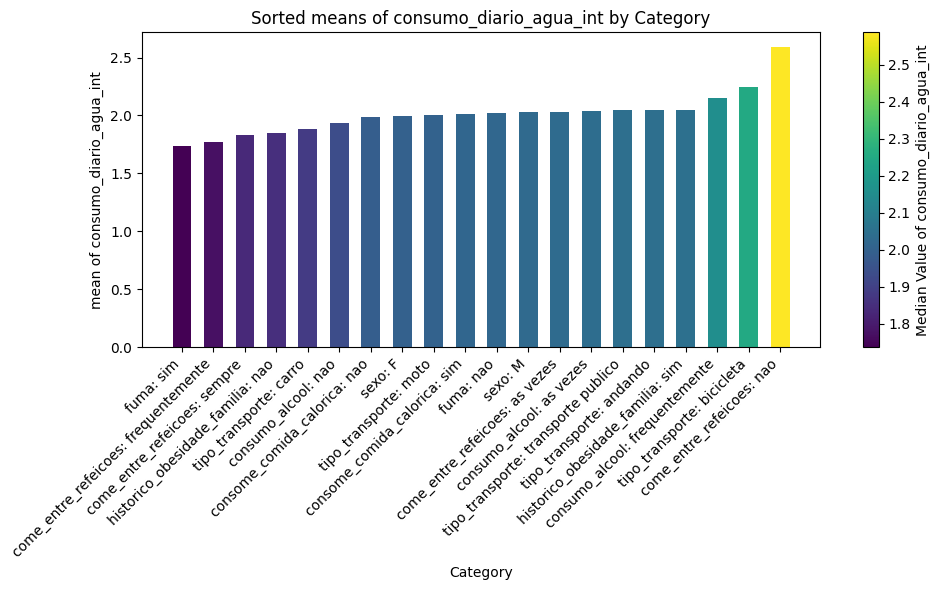

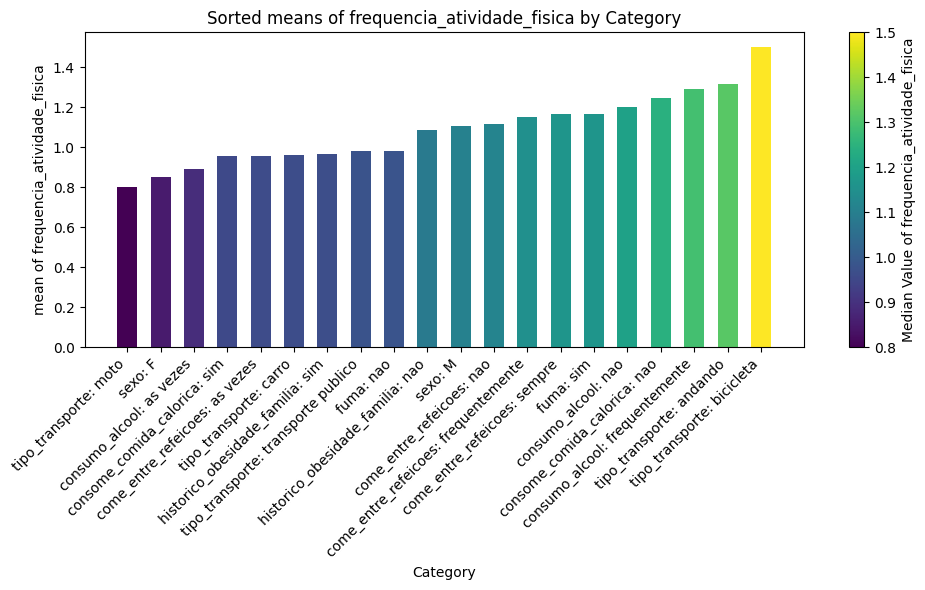

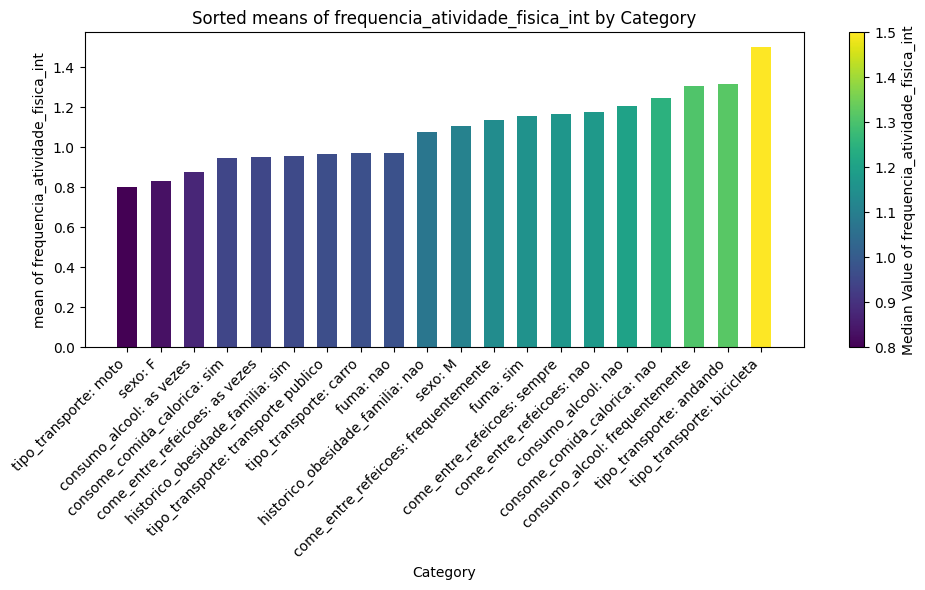

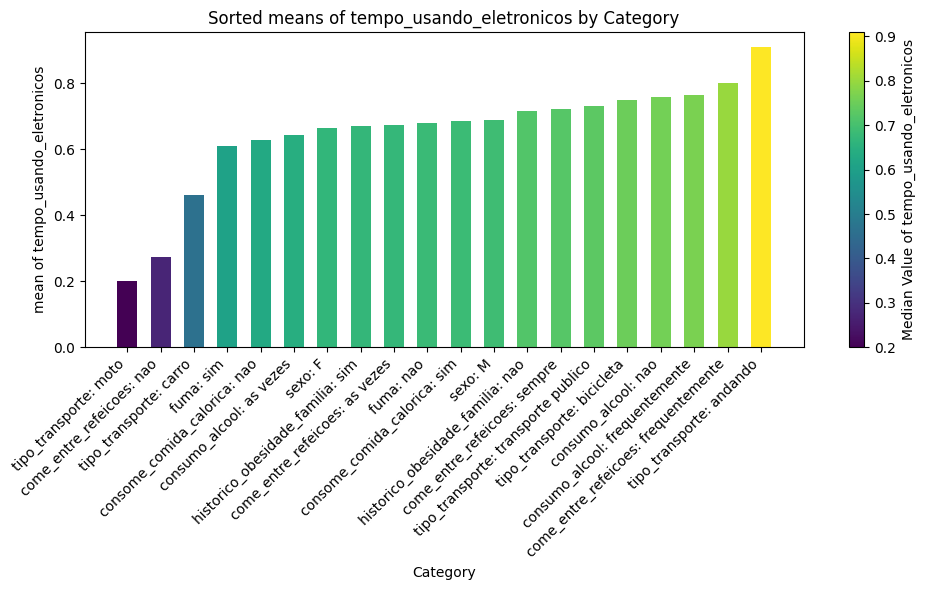

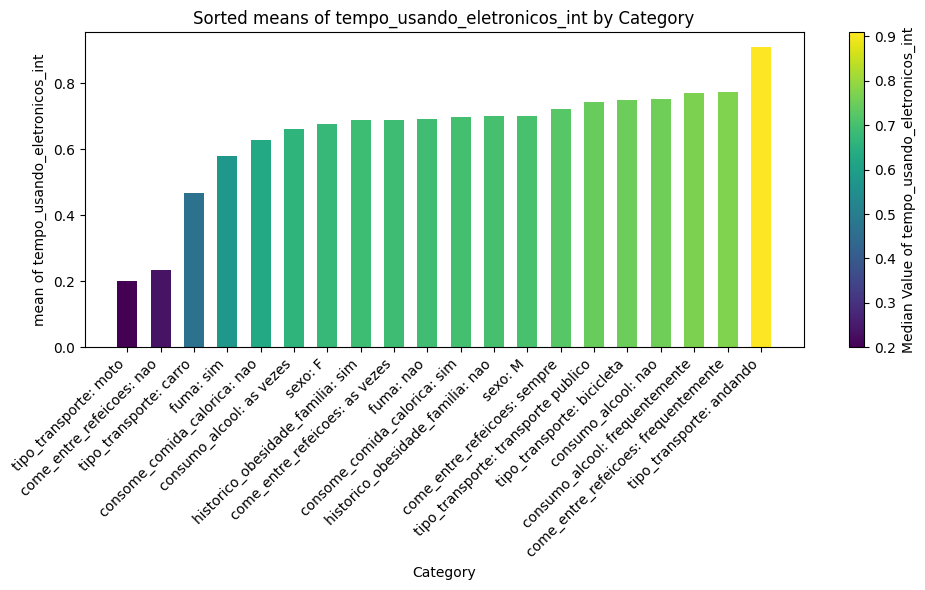

In [43]:
plot_sorted_group_metric(result_df, numerical_columns, metric='mean')

In [44]:
df

,sexo,idade,altura,peso,historico_obesidade_familia,consome_comida_calorica,consome_vegetais,n_refeicoes,come_entre_refeicoes,fuma,...,consumo_diario_agua_int,frequencia_atividade_fisica_int,tempo_usando_eletronicos_int,sexo_,historico_obesidade_familia_,consome_comida_calorica_,come_entre_refeicoes_,fuma_,consumo_alcool_,tipo_transporte_
0,M,31.264628,1.803129,91.052215,sim,sim,2.418910,3.000000,as vezes,nao,...,1.0,1.0,0.0,0,1,1,0,0,0,0
1,M,21.000000,1.620000,70.000000,nao,sim,2.000000,1.000000,nao,nao,...,3.0,1.0,0.0,0,0,1,1,0,0,0
2,F,18.019572,1.701378,50.088468,nao,sim,1.601236,3.433908,as vezes,nao,...,1.0,1.0,1.0,1,0,1,0,0,0,0
3,F,25.918524,1.621231,104.986792,sim,sim,3.000000,2.688569,as vezes,nao,...,2.0,0.0,1.0,1,1,1,0,0,0,0
4,F,33.000000,1.590000,60.000000,nao,sim,3.000000,1.000000,frequentemente,nao,...,2.0,0.0,0.0,1,0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,F,26.000000,1.640745,110.919646,sim,sim,2.418910,3.000000,as vezes,nao,...,3.0,1.0,0.0,1,1,1,0,0,0,0
1092,M,26.000000,1.700000,70.000000,sim,nao,3.000000,1.000000,frequentemente,nao,...,2.0,2.0,0.0,0,1,0,2,0,2,0
1094,F,16.000000,1.570000,49.000000,nao,sim,2.000000,4.000000,sempre,nao,...,2.0,0.0,1.0,1,0,1,3,0,0,0
1097,M,31.346845,1.823545,126.460936,sim,sim,2.938801,3.000000,as vezes,sim,...,1.0,1.0,1.0,0,1,1,0,1,0,0


In [ ]:
# df = encode_string_column(df, 'sexo', ['F', 'M'], 'sexo_M')
# df

df = encode_string_column(df, 'consumo_alcool', ['nao', 'as vezes', 'frequentemente'])
df = encode_string_column(df, 'come_entre_refeicoes', ['nao', 'as vezes', 'frequentemente', 'sempre'])

df = scale_and_prepare_data(df, category_columns, numerical_columns)

print(df.columns)
df

Index(['sexo', 'idade', 'altura', 'peso', 'historico_obesidade_familia',
       'consome_comida_calorica', 'consome_vegetais', 'n_refeicoes',
       'come_entre_refeicoes', 'fuma', 'consumo_diario_agua',
       'frequencia_atividade_fisica', 'tempo_usando_eletronicos',
       'consumo_alcool', 'tipo_transporte', 'idade_int', 'n_refeicoes_int',
       'consome_vegetais_int', 'consumo_diario_agua_int',
       'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos_int',
       'sexo_', 'historico_obesidade_familia_', 'consome_comida_calorica_',
       'come_entre_refeicoes_', 'fuma_', 'consumo_alcool_',
       'tipo_transporte_'],
      dtype='object')
Index(['idade', 'idade_int', 'altura', 'peso', 'consome_vegetais',
       'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua',
       'consumo_diario_agua_int', 'frequencia_atividade_fisica',
       'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos',
       'tempo_usando_eletronicos_int', 'sexo_F', 'sexo_M',
  

,idade,idade_int,altura,peso,consome_vegetais,consome_vegetais_int,n_refeicoes_int,consumo_diario_agua,consumo_diario_agua_int,frequencia_atividade_fisica,...,fuma_nao,fuma_sim,consumo_alcool_as vezes,consumo_alcool_frequentemente,consumo_alcool_nao,tipo_transporte_andando,tipo_transporte_bicicleta,tipo_transporte_carro,tipo_transporte_moto,tipo_transporte_transporte publico
0,1.138851,1.160285,1.050817,0.110063,8.514897e-16,-0.713967,0.387138,-1.316398,-1.474725,0.000000,...,0.150846,-0.150846,0.654289,-0.177203,-0.607116,-0.162611,-0.068599,-0.504022,-0.076742,0.56022
1,-0.539071,-0.488439,-0.903881,-0.705269,-8.032113e-01,-0.713967,-2.175775,1.636260,1.437217,0.016902,...,0.150846,-0.150846,0.654289,-0.177203,-0.607116,-0.162611,-0.068599,-0.504022,-0.076742,0.56022
2,-1.026271,-0.983057,-0.035261,-1.476424,-1.567795e+00,-0.713967,0.387138,-1.553364,-1.474725,-0.198982,...,0.150846,-0.150846,0.654289,-0.177203,-0.607116,-0.162611,-0.068599,-0.504022,-0.076742,0.56022
3,0.264943,0.171050,-0.890741,0.649736,1.114173e+00,1.038124,0.387138,0.000000,-0.018754,-1.011375,...,0.150846,-0.150846,0.654289,-0.177203,-0.607116,-0.162611,-0.068599,-0.504022,-0.076742,0.56022
4,1.422526,1.490029,-1.224097,-1.092560,1.114173e+00,1.038124,-2.175775,-0.003666,-0.018754,-1.177601,...,0.150846,-0.150846,-1.528377,-0.177203,1.647132,-0.162611,-0.068599,-0.504022,-0.076742,0.56022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,0.278261,0.335923,-0.682451,0.879510,8.514897e-16,-0.713967,0.387138,1.088817,1.437217,0.000000,...,0.150846,-0.150846,0.654289,-0.177203,-0.607116,-0.162611,-0.068599,-0.504022,-0.076742,0.56022
1092,0.278261,0.335923,-0.049970,-0.705269,1.114173e+00,1.038124,-2.175775,-0.003666,-0.018754,1.211404,...,0.150846,-0.150846,-1.528377,5.643240,-0.607116,-0.162611,-0.068599,-0.504022,-0.076742,0.56022
1094,-1.356403,-1.312801,-1.437575,-1.518580,-8.032113e-01,-0.713967,1.668594,0.000000,-0.018754,-1.177601,...,0.150846,-0.150846,0.654289,-0.177203,-0.607116,-0.162611,-0.068599,-0.504022,-0.076742,0.56022
1097,1.152291,1.160285,1.268735,1.481410,9.968311e-01,1.038124,0.387138,-0.858077,-1.474725,-0.046690,...,-6.629281,6.629281,0.654289,-0.177203,-0.607116,-0.162611,-0.068599,-0.504022,-0.076742,0.56022


In [46]:
print(df.columns)

Index(['idade', 'idade_int', 'altura', 'peso', 'consome_vegetais',
       'consome_vegetais_int', 'n_refeicoes_int', 'consumo_diario_agua',
       'consumo_diario_agua_int', 'frequencia_atividade_fisica',
       'frequencia_atividade_fisica_int', 'tempo_usando_eletronicos',
       'tempo_usando_eletronicos_int', 'sexo_F', 'sexo_M',
       'historico_obesidade_familia_nao', 'historico_obesidade_familia_sim',
       'consome_comida_calorica_nao', 'consome_comida_calorica_sim',
       'come_entre_refeicoes_as vezes', 'come_entre_refeicoes_frequentemente',
       'come_entre_refeicoes_nao', 'come_entre_refeicoes_sempre', 'fuma_nao',
       'fuma_sim', 'consumo_alcool_as vezes', 'consumo_alcool_frequentemente',
       'consumo_alcool_nao', 'tipo_transporte_andando',
       'tipo_transporte_bicicleta', 'tipo_transporte_carro',
       'tipo_transporte_moto', 'tipo_transporte_transporte publico'],
      dtype='object')


In [47]:
# columns_to_drop = ['idade', 'consome_vegetais', 'consumo_diario_agua', 'frequencia_atividade_fisica', 'tempo_usando_eletronicos']

# df = df[[x for x in df.columns if x not in columns_to_drop]]
# df

In [48]:
from sklearn import cluster

# kmeans = cluster.MiniBatchKMeans( n_clusters=3, batch_size=10 )
kmeans = cluster.KMeans(n_clusters=3)
y_kmeans = kmeans.fit_predict(df)

print(set(kmeans.labels_))

{np.int32(0), np.int32(1), np.int32(2)}


In [49]:
dbscan = cluster.DBSCAN(eps=0.3, min_samples=10)
y_dbscan = dbscan.fit_predict(df)

print(set(dbscan.labels_))

{np.int64(0), np.int64(-1)}


In [50]:
from sklearn import metrics

silhouette_score_k_means = metrics.silhouette_score(df, y_kmeans, metric="euclidean")
print("Silhouette Score KMeans: %f"%(silhouette_score_k_means))

silhouette_score_dbscan = metrics.silhouette_score(df, y_dbscan, metric="euclidean")
print("Silhouette Score DBSCAN: %f"%(silhouette_score_dbscan))

Silhouette Score KMeans: 0.135288
Silhouette Score DBSCAN: -0.128993
